<h1><span style='font-family: "Trebuchet MS", Helvetica, sans-serif;'>Automatic Ticket Classification - EDA
</span></h1>

In [1]:
# !pip install langdetect
# or
# !conda install -c conda-forge langdetect
#
# !pip install wordcloud
# or
# !conda install -c conda-forge wordcloud

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# imports

import os
import math
import random
import warnings
from time import time
from pathlib import Path
import pandas as pd, numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict, Counter
from langdetect import detect_langs, LangDetectException
from wordcloud import WordCloud, STOPWORDS
import tensorflow

tqdm.pandas()
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

C:\Users\surya\anaconda3\envs\full\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
# reproducibility
seed = 7
random.seed(seed)
tensorflow.random.set_seed(seed)

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Import & Analyse the data.</span></strong></li>
</ul></h3>

In [5]:
dataset = pd.read_excel('./data/input_data.xlsx')
dataset.sample(7)

Short description  \
1725         user was unable to open reporting_tool   
2821                company center-password changes   
5088                     unlock account lichtyuiwu7   
2938  please delete the attached series of meetings   
2292                         upgrade to office 2016   
2994           unlock erp account (user id: murakt)   
2887     wi- fi access to user jamhdtyes kinhytudel   

                                            Description             Caller  \
1725             user was unable to open reporting_tool  mwjcsiug fbwthoca   
2821  i have been setting users up in company center...  qcfmxgid jvxanwre   
5088                         unlock account lichtyuiwu7  aorthyme rnsuipbk   
2938  meeting was scheduled by a former employee\r\n...  jhwgydeb ufiatosg   
2292  currently there are two versions of office on ...  zmnhfcbv azdnkmul   
2994     please unlock my erp account (user id: murakt)  knpodsal pzdkcimf   
2887         wi- fi access to user jamhdtyes kinhytudel  kauozcir jlyqxise   

     Assignment group  
1725            GRP_0  
2821            GRP_0  
5088            GRP_0  
2938           GRP_26  
2292            GRP_0  
2994            GRP_0  
2887            GRP_0

In [6]:
dataset.shape  # very small dataset with only 8500 rows

(8500, 4)

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


In [8]:
# rename column names for convenience
dataset = dataset.rename(columns={
    "Short description": "short_description",
    "Description": "description",
    "Caller": "caller",
    "Assignment group": "group"
    })

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   short_description  8492 non-null   object
 1   description        8499 non-null   object
 2   caller             8500 non-null   object
 3   group              8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


In [10]:
np.unique(dataset.group), len(np.unique(dataset.group))  # 74 different functional groups

(array(['GRP_0', 'GRP_1', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
        'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
        'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
        'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_3', 'GRP_30',
        'GRP_31', 'GRP_32', 'GRP_33', 'GRP_34', 'GRP_35', 'GRP_36',
        'GRP_37', 'GRP_38', 'GRP_39', 'GRP_4', 'GRP_40', 'GRP_41',
        'GRP_42', 'GRP_43', 'GRP_44', 'GRP_45', 'GRP_46', 'GRP_47',
        'GRP_48', 'GRP_49', 'GRP_5', 'GRP_50', 'GRP_51', 'GRP_52',
        'GRP_53', 'GRP_54', 'GRP_55', 'GRP_56', 'GRP_57', 'GRP_58',
        'GRP_59', 'GRP_6', 'GRP_60', 'GRP_61', 'GRP_62', 'GRP_63',
        'GRP_64', 'GRP_65', 'GRP_66', 'GRP_67', 'GRP_68', 'GRP_69',
        'GRP_7', 'GRP_70', 'GRP_71', 'GRP_72', 'GRP_73', 'GRP_8', 'GRP_9'],
       dtype=object),
 74)

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Check for Incomplete Information</span></strong></li>
</ul></h3>

In [11]:
dataset.isna().sum()  # Few missing values

short_description    8
description          1
caller               0
group                0
dtype: int64

In [12]:
dataset[dataset.isna().any(axis=1)]  # check rows with missing values

short_description  \
2604                       NaN   
3383                       NaN   
3906                       NaN   
3910                       NaN   
3915                       NaN   
3921                       NaN   
3924                       NaN   
4341                       NaN   
4395  i am locked out of skype   

                                            description             caller  \
2604  \r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...  ohdrnswl rezuibdt   
3383  \r\n-connected to the user system using teamvi...  qftpazns fxpnytmk   
3906  -user unable  tologin to vpn.\r\n-connected to...  awpcmsey ctdiuqwe   
3910  -user unable  tologin to vpn.\r\n-connected to...  rhwsmefo tvphyura   
3915  -user unable  tologin to vpn.\r\n-connected to...  hxripljo efzounig   
3921  -user unable  tologin to vpn.\r\n-connected to...  cziadygo veiosxby   
3924  name:wvqgbdhm fwchqjor\nlanguage:\nbrowser:mic...  wvqgbdhm fwchqjor   
4341  \r\n\r\nreceived from: eqmuniov.ehxkcbgj@gmail...  eqmuniov ehxkcbgj   
4395                                                NaN  viyglzfo ajtfzpkb   

       group  
2604  GRP_34  
3383   GRP_0  
3906   GRP_0  
3910   GRP_0  
3915   GRP_0  
3921   GRP_0  
3924   GRP_0  
4341   GRP_0  
4395   GRP_0

In [13]:
dataset.loc[dataset['description'].isna()]

short_description description             caller  group
4395  i am locked out of skype         NaN  viyglzfo ajtfzpkb  GRP_0

In [14]:
dataset.iloc[4395]

short_description    i am locked out of skype
description                               NaN
caller                      viyglzfo ajtfzpkb
group                                   GRP_0
Name: 4395, dtype: object

In [15]:
# imputing the short description by value in description and vice-versa
# However, If both columns were missing, we would have to drop the row
dataset.loc[dataset['description'].isna(), 'description']  = dataset.loc[dataset['description'].isna()].short_description

In [16]:
dataset.loc[dataset['short_description'].isna()]

short_description                                        description  \
2604               NaN  \r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...   
3383               NaN  \r\n-connected to the user system using teamvi...   
3906               NaN  -user unable  tologin to vpn.\r\n-connected to...   
3910               NaN  -user unable  tologin to vpn.\r\n-connected to...   
3915               NaN  -user unable  tologin to vpn.\r\n-connected to...   
3921               NaN  -user unable  tologin to vpn.\r\n-connected to...   
3924               NaN  name:wvqgbdhm fwchqjor\nlanguage:\nbrowser:mic...   
4341               NaN  \r\n\r\nreceived from: eqmuniov.ehxkcbgj@gmail...   

                 caller   group  
2604  ohdrnswl rezuibdt  GRP_34  
3383  qftpazns fxpnytmk   GRP_0  
3906  awpcmsey ctdiuqwe   GRP_0  
3910  rhwsmefo tvphyura   GRP_0  
3915  hxripljo efzounig   GRP_0  
3921  cziadygo veiosxby   GRP_0  
3924  wvqgbdhm fwchqjor   GRP_0  
4341  eqmuniov ehxkcbgj   GRP_0

In [17]:
dataset.loc[dataset['short_description'].isna(), 'short_description']  = dataset.loc[dataset['short_description'].isna()].description

In [18]:
dataset.isna().sum()  # all missing values imputed

short_description    0
description          0
caller               0
group                0
dtype: int64

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Target Class Distribution</span></strong></li>
</ul></h3>

In [140]:
sns.set(font_scale=1.10)  # scale up font size
dataset.group.value_counts().sort_values(ascending = True).plot(kind='barh', width=0.75, figsize=(15, 15), color='#50C878')
plt.xticks(rotation=45)
plt.show()

<h5><ul>
<span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">
    <li>The target class distribution is heavily imbalanced as most calls are assinged to Group 0 and exluding this as well, we find an imabalanced dataset for the rest of the groups.
 </span></ul></h5>

In [53]:
temp = dataset.copy(deep=True)
temp.loc[temp["group"] != 'GRP_0', 'group'] = 'Other'
temp.loc[temp["group"] == 'GRP_0', "group"] = 'Group 0'

In [54]:
temp.group.value_counts()

Other      4524
Group 0    3975
Name: group, dtype: int64

In [55]:
sns.set(font_scale=1.25)  # scale up font size

plt.figure(figsize=(5, 5), dpi=125)
group_0 = len(temp[temp['group'] == 'Group 0'])
others = len(temp[temp['group'] == 'Other'])

plt.pie(x=[group_0, others],
        explode=(0, 0),
        labels=['Group 0', 'All Other Groups Combined'],
        autopct='%1.2f%%',
        shadow=True,
        startangle=70,
        colors=['#FF4500', '#50C878'])

fig = plt.gcf()
fig.set_size_inches(5, 5)
plt.title('Groups')
plt.show()

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Outlier Analysis</span></strong></li>
</ul></h3>

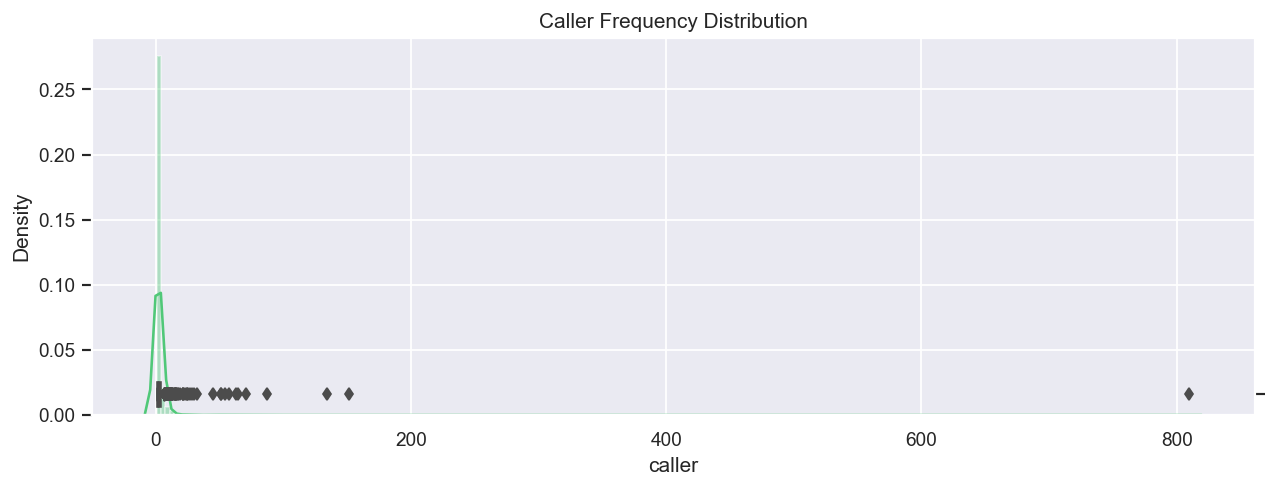

In [19]:
# plotting caller frequency counts
sns.set()
plt.figure(figsize=(12, 4), dpi=125)
ax = sns.distplot(dataset.caller.value_counts(), bins=250, kde=True, color='#50C878')
ax_ = ax.twinx()
sns.boxplot(dataset.caller.value_counts(), color='#FF4500')
ax_.set(ylim=(-.7, 12))
plt.title('Caller Frequency Distribution')
plt.show()

In [20]:
def get_length(row):
    try:
        row['char_length'] = len(row.description)
        row['word_length'] = len(row.description.split())
        row['short_char_length'] = len(row.short_description)
        row['short_word_length'] = len(row.short_description.split())
    except Exception:  # assign 0 length to missing rows
        row['char_length'] = 0
        row['word_length'] = 0
        row['short_char_length'] = 0
        row['short_word_length'] = 0
    return row

dataset = dataset.progress_apply(get_length, axis=1)

100%|█████████████████████████████████████████████████████████████████████████████| 8500/8500 [00:14<00:00, 591.63it/s]


In [21]:
dataset.sample(7)

short_description  \
7415                               bitte um ein ruckruf   
4211  network outage:usa mi :brembo: site hard down ...   
1168  setup EU_tool \we_wu185 \8323738 \jionmpsf wnk...   
576                call from salesforce for hathryrtmut   
5053       what's the meaning of this "warning message"   
5520            request for company.com email address.    
6882  job Job_480 failed in job_scheduler at: 08/20/...   

                                            description             caller  \
7415  \n\nreceived from: zkgfcyvx.sgxeatyb@gmail.com...  zkgfcyvx sgxeatyb   
4211  what type of outage:  __x___network     _____c...  mnlazfsr mtqrkhnx   
1168  setup EU_tool \we_wu185 \8323738 \jionmpsf wnk...  jionmpsf wnkpzcmv   
576   caller named benjamtrhdyin from salesforce wan...  ayrhcfxi zartupsw   
5053  \n\nreceived from: zywoxerf.paqxtrfk@gmail.com...  zywoxerf paqxtrfk   
5520  from: jertyur hanna \r\nsent: thursday, septem...  fljhvdsn kiyzclao   
6882  received from: monitoring_tool@company.com\r\n...  bpctwhsn kzqsbmtp   

       group  char_length  word_length  short_char_length  short_word_length  
7415   GRP_0          690           90                 20                  4  
4211   GRP_8         1161          129                 75                 13  
1168  GRP_24           51            6                 51                  6  
576    GRP_0           72           10                 36                  5  
5053   GRP_0          319           39                 44                  7  
5520  GRP_26          174           23                 39                  5  
6882   GRP_8          105           11                 61                  8

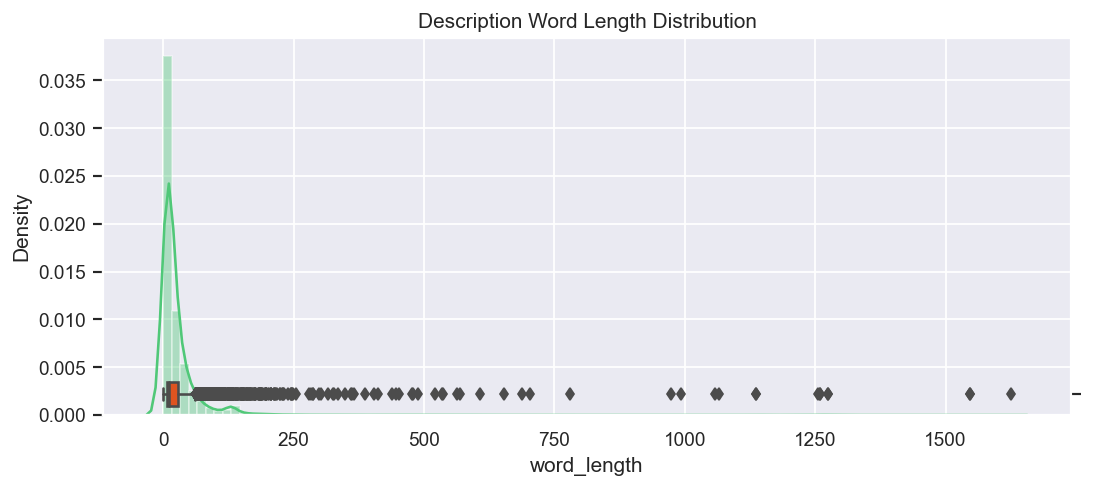

In [22]:
sns.set()
plt.figure(figsize=(10, 4), dpi=125)
ax = sns.distplot(dataset.word_length, bins=100, kde=True, color='#50C878')
ax_ = ax.twinx()
sns.boxplot(dataset.word_length, color='#FF4500')
ax_.set(ylim=(-.7, 12))
plt.title('Description Word Length Distribution')
plt.show()

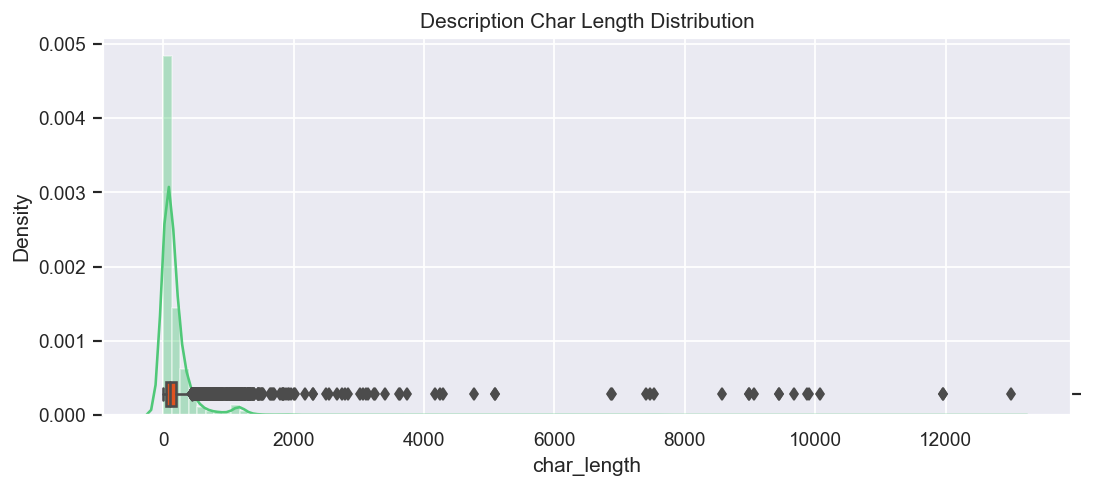

In [23]:
sns.set()
plt.figure(figsize=(10, 4), dpi=125)
ax = sns.distplot(dataset.char_length, bins=100, kde=True, color='#50C878')
ax_ = ax.twinx()
sns.boxplot(dataset.char_length, color='#FF4500')
ax_.set(ylim=(-.7, 12))
plt.title('Description Char Length Distribution')
plt.show()

In [24]:
dataset[dataset.word_length == 0]  # empty description => imputing with the corresponding short_description

short_description description             caller  group  \
6371   authorization add/delete members    \r\n\r\n  hpmwliog kqtnfvrl  GRP_0   
7397                   browser issue :         \r\n  fgejnhux fnkymoht  GRP_0   

      char_length  word_length  short_char_length  short_word_length  
6371            5            0                 33                  3  
7397            2            0                 16                  3

In [25]:
dataset.loc[dataset.word_length == 0, 'description'] = dataset.loc[dataset.word_length == 0]['short_description']
dataset = dataset.progress_apply(get_length, axis=1)

100%|████████████████████████████████████████████████████████████████████████████| 8500/8500 [00:00<00:00, 9330.44it/s]


In [26]:
dataset[dataset.word_length == 0]  # cleaned

Empty DataFrame
Columns: [short_description, description, caller, group, char_length, word_length, short_char_length, short_word_length]
Index: []

In [27]:
dataset[dataset.char_length < 4]  # description 'the' holds no information => imputed with short_description

short_description description  \
1049  reset passwords for soldfnbq uhnbsvqd using pa...         the   
1054  reset passwords for fygrwuna gomcekzi using pa...         the   
1144  reset passwords for wvdxnkhf jirecvta using pa...         the   
1184  reset passwords for pxvjczdt kizsjfpq using pa...         the   
1292  reset passwords for cubdsrml znewqgop using pa...         the   
1476  reset passwords for bnoupaki cpeioxdz using pa...         the   
1558  reset passwords for usa feathers using passwor...         the   
1693  reset passwords for eglavnhx uprodleq using pa...         the   
1834  reset passwords for hybiaxlk lawptzir using pa...         the   
1850  reset passwords for fylrosuk kedgmiul using pa...         the   
1851  reset passwords for fylrosuk kedgmiul using pa...         the   
1860                                                  s           s   
2151  reset passwords for gjisfonb odwfhmze using pa...         the   
2532  reset passwords for qwsjptlo hnlasbed using pa...         the   
2533  reset passwords for qwsjptlo hnlasbed using pa...         the   
2553  reset passwords for bxeagsmt zrwdgsco using pa...         the   
2554  reset passwords for bxeagsmt zrwdgsco using pa...         the   
2572  reset passwords for prgewfly ndtfvple using pa...         the   
2602  reset passwords for wxdvjoct ckxwtoam using pa...         the   
2605  reset passwords for ytzpxhql ntfxgpms using pa...         the   
2749  reset passwords for fkuqjwit jgcsaqzi using pa...         the   
2788  reset passwords for hzmxwdrs tcbjyqps using pa...         the   
3000  reset passwords for knemilvx dvqtziya using pa...         the   
3432                                                dds         dss   
3447  reset passwords for qoybxkfh dwcmxuea using pa...         the   
3692  reset passwords for mvhcoqed konjdmwq using pa...         the   
3693  reset passwords for mvhcoqed konjdmwq using pa...         the   
4055  reset passwords for jerydwbn gdylnaue using pa...         the   
4065  reset passwords for dmexgspl mruzqhac using pa...         the   
4672  reset passwords for robhyertyj f duca using pa...         the   
4978  reset passwords for davidthd robankm using pas...         the   
4984  reset passwords for cubdsrml znewqgop using pa...         the   
4991  reset passwords for davidthd robankm using pas...         the   
5074  reset passwords for mafgtnik -0 using password...         the   
5077  reset passwords for cÃ©sar abreu rghkiriuytes ...         the   
5182  reset passwords for yolktfas fyoxqgvh using pa...         the   
5228  reset passwords for ugawcoye jcfqgviy using pa...         the   
5305  reset passwords for qgilmtyc gmscovxa using pa...         the   
5317  reset passwords for bxeagsmt zrwdgsco using pa...         the   
5482  reset passwords for qycgdfhz iqshzdru using pa...         the   
5708  reset passwords for bxeagsmt zrwdgsco using pa...         the   
5839  reset passwords for cpmaidhj elbaqmtp using pa...         the   
5884  reset passwords for bxeagsmt zrwdgsco using pa...         the   
6037  reset passwords for cesgrtar abgrtyreu using p...         the   
6058  reset passwords for bxeagsmt zrwdgsco using pa...         the   
6693  reset passwords for pzjelyxg vstyaouc using pa...         the   
6764  reset passwords for horeduca ogrhivnm using pa...         the   
6819  reset passwords for wvdxnkhf jirecvta using pa...         the   
6963  reset passwords for patrcja szpilewska using p...         the   
7131  reset passwords for ezrsdgfc hofgvwel using pa...         the   
7132  reset passwords for ezrsdgfc hofgvwel using pa...         the   
7169  reset passwords for andrdgrtew p taneghrty usi...         the   
7630  reset passwords for jcmxerol nbfyczqr using pa...         the   
7875  reset passwords for esias bosch using password...         the   
8059  reset passwords for wptbgchj jutpdcqf using pa...         the   
8092  reset passwords for prgthyuulla ramdntythanjes...       

In [28]:
dataset.loc[dataset.description == 'the', 'description'] = dataset.loc[dataset.description == 'the']['short_description']
dataset = dataset.progress_apply(get_length, axis=1)

100%|███████████████████████████████████████████████████████████████████████████| 8500/8500 [00:00<00:00, 10340.67it/s]


In [29]:
# dataset[dataset.word_length == 1].to_csv('./data/Single_Word_Descriptions.csv')
dataset[dataset.word_length == 1].sample(20)  # these have to be cleaned up and imputed later on

short_description  \
416   reset the password for prgewfly ndtfvple on er...   
618                                    outlookæ‰“ä¸å¼€   
1178                              ç”µè¯æœºæ²¡æœ‰å£°éŸ³   
8266         erpæ— æ³•è¿›è¡Œé‡‡è´­ï¼ˆè½¬ç»™è´ºæ­£å¹³ï¼‰   
5147                                 ç”µè„‘å¼€æœºæ•…éšœ   
6534                  æ¶‚å±‚ã€ç®¡ä¸è½¦é—´ç”µè¯æ•…éšœ   
7302                               skypeä¼šè®®æ—¶ä¸åŽ»   
6253  in the inbox always show there are several ema...   
4505   request to reset microsoft online services pa...   
4569  i am not able to connect to my regular printer...   
1955                     æœ‰ä¸€ä¸ªé“¾æŽ¥æ–‡ä»¶æ‰“ä¸å¼€   
2267  urgent help required- outlook to crm mfg_toolt...   
5149                                       å¼€ä¸äº†æœº   
7969               å®¢æˆ·æä¾›çš„åœ¨çº¿ç³»ç»Ÿæ‰“ä¸å¼€   
5491                    é›»è…¦å‡ºç¾è—å±,ç„¡æ³•é–‹æ©Ÿ   
3315                        ç”µè„‘ç³»ç»Ÿå¯åŠ¨è“å±ã€‚   
3120               ç”µè„‘ç¡¬ç›˜æ•…éšœï¼Œè¯·æ±‚ç»´ä¿®ã€‚   
7588                                    æ˜¾ç¤ºå™¨ä¸äº®   
1081                                 ç”¨å‹è½¯ä»¶é—®é¢˜   
5762       æ‰“å¼€office 2013æ˜¾ç¤ºæ˜¯æœªç»æŽˆæƒäº§å“   

                                            description             caller  \
416                                           completed  prgewfly ndtfvple   
618   æ‰“å¼€outlookæ—¶ï¼Œæ˜¾ç¤ºoutlook.ostæ–‡ä»¶é”™è...  qayozbcd vwglmpjq   
1178                              ç”µè¯æœºæ²¡æœ‰å£°éŸ³  cyjlqdwm kywiuosn   
8266  è¿›è¡Œé‡‡è´­æ—¶æ˜¾ç¤º"æ‰¾ä¸åˆ°å‘˜å·¥111115483...  kyagjxdh dmtjpbnz   
5147  åŽŸææ–™ä»“åº“ç”µè„‘å¼€æœºè“å±ï¼Œä¸»æœºé¢æ...  ycjxrsba ehftdorm   
6534  æ¶‚å±‚ã€ç®¡ä¸è½¦é—´ç”µè¯æ•…éšœï¼Œ40634943ã€...  vrmpysoz qkiucpdx   
7302       skypeä¼šè®®ä»Žé‚®ç®±é‡Œçš„é“¾æŽ¥è¿›ä¸åŽ»ã€‚  rekpvblc ufysatml   
6253                                              +86    mqbxwpfn uclrqfxa   
4505                                      \r\n\r\nkind   rcfwnpbi kvhedyrc   
4569                                             x5380   koiapqbg teyldpkw   
1955      æœ‰ä¸€é“¾æŽ¥æ–‡ä»¶æ‰“ä¸å¼€ï¼Œæç¤ºç‰ˆæœ¬ä½Ž  qsfcxzel quwykhno   
2267                                           contact   gonflcmq wmptisvz   
5149               å¼€ä¸äº†æœºï¼Œæ˜¾ç¤ºç³»ç»Ÿåäº†ã€‚  kclhqspo xvugztyc   
7969  å®¢æˆ·æä¾›çš„åœ¨çº¿é€è´§å•ç”Ÿæˆç³»ç»Ÿæ‰“ä...  fupikdoa gjkytoeh   
5491  é€£vpnæ™‚,ç„¡æ³•é€£ä¸Šå¾Œ,é‡è©¦å¾Œ,çªç„¶å‡ºç...  zhpwcdea cboefuis   
3315  ç”µè„‘ç³»ç»Ÿå¯åŠ¨è“å±ã€‚æ°´ä¸å°å¿ƒæ´’åˆ°ç...  hdungfsc znuhyjkx   
3120               ç”µè„‘ç¡¬ç›˜æ•…éšœï¼Œè¯·æ±‚ç»´ä¿®ã€‚  ruhbyzpv vlksnjti   
7588            æ—©ä¸Šå¼€æœºåŽæ˜¾ç¤ºå™¨ä¸å‡ºå›¾åƒã€‚  wgmqlnzh vpebwoat   
1081  æ‰“å¼€å·²å…³é—­çš„é”€å”®è®¢å•æ—¶ï¼Œæ˜¾ç¤º"ä¸...  bwstnmjh yqumwrsk   
5762  æ‰“å¼€outlookã€pptæ˜¾ç¤ºæ˜¯æœªç»æŽˆæƒäº§å“...  hbvwqine eakqyovu   

       group  char_length  word_length  short_char_length  short_word_length  
416    GRP_0            9            1                 67                 12  
618    GRP_0           72            1                 16                  1  
1178  GRP_30           21            1                 21                  1  
8266  GRP_30           84            1                 42                  2  
5147  GRP_48           68            1                 18                  1  
6534  GRP_48           55            1                 33                  1  
7302  GRP_30           44            1                 20                  1  
6253   GRP_0            5            1                 94                 19  
4505   GRP_0            9            1                 84                  9  
4569   GRP_0            6            1                 84                 16  
1955  GRP_30           45            1                 30                  1  
2267   GRP_0            8            1                 56                  8  
5149  GRP_30           36            1                 12                  1  
7969  GRP_48           69            1               

In [30]:
dataset[dataset.word_length == 2].sample(20)

short_description  \
6625                                    account locked.   
4637                                        erp queries   
1480                                     password reset   
1430                                    invoicing error   
5989                                     account unlock   
526                                      password reset   
4718                                    account locked.   
5123  collaboration_platform é‡Œé¢æ‰“å¼€"æŸ¥çœ‹æˆ‘ç...   
5288  i'm on vacation, and my vpn isn't working.  ca...   
823                                             no boot   
5314                                    account locked.   
230                                         blank call    
6603                                     account unlock   
8175                                     password reset   
8496                           telephony_software issue   
5973                                   outlook freezes.   
710                                         missed call   
311                                      ticket update    
4090  çƒ­åŽ‹ç‚‰4å·plcæŽ§åˆ¶å™¨é€šè®¯æ¨¡å—ç½‘ç»œåœ°...   
4813                                        skype error   

                                            description             caller  \
6625                                    account locked.  vfoyenlw ntpbdeyf   
4637                                        erp queries  esuizcrh nytvhmbq   
1480                                     password reset  rhpqxsuy vcukgdfe   
1430                                    invoicing error  yhmwxsqj ugnthxky   
5989                                     account unlock  jusenflm sufbehom   
526                                      password reset  phksfqxe wkbovsmu   
4718                                    account locked.  qrstgxwn fhpyxgjz   
5123  collaboration_platform é‡Œé¢æ‰“å¼€"æŸ¥çœ‹æˆ‘ç...  lkrfndev kztlojin   
5288                                              , vpn  koiapqbg teyldpkw   
823                                             no boot  jinyluhq wpvelhtz   
5314                                    account locked.  zrcfyiea gynbmopr   
230                                         blank call   rbozivdq gmlhrtvp   
6603                                     account unlock  jusenflm sufbehom   
8175                                     password reset  gsyjxfur nuwoikzj   
8496                           telephony_software issue  rbozivdq gmlhrtvp   
5973                                   outlook freezes.  rwhavckz drvxyihj   
710                                         missed call  fumkcsji sarmtlhy   
311                                      ticket update   pbhmwqtz wqlbudjx   
4090  ä»Šå¹´å‘ç”Ÿäº†5æ¬¡ç½‘ç»œåœ°å€ä¸¢å¤±ï¼Œéœ€è¦...  pwfirvgu ydwlhuzi   
4813                                        skype error  zfdkqgmt zvqxcodk   

       group  char_length  word_length  short_char_length  short_word_length  
6625   GRP_0           15            2                 15                  2  
4637   GRP_0           11            2                 11                  2  
1480   GRP_0           14            2                 14                  2  
1430  GRP_13           15            2                 15                  2  
5989   GRP_0           14            2                 14                  2  
526    GRP_0           14            2                 14                  2  
4718   GRP_0           15            2                 15                  2  
5123  GRP_31           82            2                 88                  2  
5288  GRP_50            5            2                 68                 14  
823    GRP_0            7            2                  7                  2  
5314   GRP_0           15            2                 15                  2  
230    GRP_0           11            2                 11                  2  
6603   GRP_0           14            2                 14                  2  
8175   GRP_0           14            2               

In [31]:
dataset[dataset.short_word_length == 0]  # all have short descriptions

Empty DataFrame
Columns: [short_description, description, caller, group, char_length, word_length, short_char_length, short_word_length]
Index: []

In [32]:
dataset[dataset.short_char_length < 3]  # row 1860 seems to have no information whatsoever with just a single character, row has to be dropped.

short_description                                        description  \
1860                 s                                                  s   
3529                PR  create a purchase requisition with purchasing ...   

                 caller   group  char_length  word_length  short_char_length  \
1860  gzjtweph mnslwfqv   GRP_0            1            1                  1   
3529  ejvkzobl yijgokrn  GRP_29          201           31                  2   

      short_word_length  
1860                  1  
3529                  1

In [33]:
dataset = dataset.drop([1860])
dataset = dataset.progress_apply(get_length, axis=1)

100%|████████████████████████████████████████████████████████████████████████████| 8499/8499 [00:00<00:00, 9768.97it/s]


In [34]:
dataset[dataset.short_char_length < 3]

short_description                                        description  \
3529                PR  create a purchase requisition with purchasing ...   

                 caller   group  char_length  word_length  short_char_length  \
3529  ejvkzobl yijgokrn  GRP_29          201           31                  2   

      short_word_length  
3529                  1

In [35]:
dataset[dataset.short_word_length == 1].sample(20)

short_description  \
3274                                          password    
1197                                              skype   
276   outlookæ”¶åˆ°ç®±ä¸­folderå˜ä¸ºæ¯å¤©ä¸€ä¸ªfol...   
3538                                        lcowx216132   
1836                        bgflmyar.xgufkidq@gmail.com   
6846                                           password   
3740                                          upsæ•…éšœ   
3204                                                crm   
5111                                          babiluntr   
718                                               skype   
3943                                        crm/outlook   
5147                                 ç”µè„‘å¼€æœºæ•…éšœ   
1312                                               bobj   
3242                                               help   
1                                               outlook   
3917                                               vpn    
1710                           äº§å“ä¸Žä»“åº“å¯¹ä¸ä¸Š   
295                                         outlook/crm   
6106                                 ç”µè„‘ä¸èƒ½å¼€æœº   
4376                                             remove   

                                            description             caller  \
3274  \r\n\r\nreceived from: woxrljif.qymrszdk@gmail...  woxrljif qymrszdk   
1197  \r\n\r\nreceived from: nuhfwplj.ojcwxser@gmail...  nuhfwplj ojcwxser   
276   outlookæ”¶åˆ°ç®±ä¸­folderå˜ä¸ºæ¯å¤©ä¸€ä¸ªfol...  bxfdkiol mdqlszvc   
3538  \n\nreceived from: zwirhcol.narzlmfw@gmail.com...  zwirhcol narzlmfw   
1836  bgflmyar.xgufkidq@gmail.com wanted to check if...  olckhmvx pcqobjnd   
6846  \r\n\r\nreceived from: rgtarthi.erjgypa@compan...  xqoljzbh aydcwkxt   
3740  åˆ¶ç²‰è½¦é—´3æ¥¼psfäº¤æ¢æœºå¤„upsæ•…éšœï¼Œè®¾...  agyvbnwz mxsonkdc   
3204  \r\n\r\nreceived from: saqbgcpl.ybfzcjiq@gmail...  saqbgcpl ybfzcjiq   
5111  \r\n\r\nreceived from: dhtxwcng.hruckmey@gmail...  dhtxwcng hruckmey   
718   \r\n\r\nreceived from: yiramdntyjqc.qtrcepsa@g...  yiramjqc qtrcepsa   
3943  \n\nreceived from: zolnubvq.ehrqifxp@gmail.com...  zolnubvq ehrqifxp   
5147  åŽŸææ–™ä»“åº“ç”µè„‘å¼€æœºè“å±ï¼Œä¸»æœºé¢æ...  ycjxrsba ehftdorm   
1312  \r\n\r\nreceived from: vxzahrlc.frtkpehy@gmail...  vxzahrlc frtkpehy   
3242  \r\n\r\nreceived from: lanigpkq.qzhakunx@gmail...  lanigpkq qzhakunx   
1     \r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...  hmjdrvpb komuaywn   
3917  \n\nreceived from: oetlgbfw.bsctrnwp@gmail.com...  oetlgbfw bsctrnwp   
1710  äº§å“æ‰€åœ¨ä»“åº“å‡ºé”™ã€‚ st6p  -100/+325   ...  tvykmlex hcawjigf   
295   \r\n\r\nreceived from: anpocezt.qturbxsg@gmail...  anpocezt qturbxsg   
6106                     æ—©ä¸Šä¸Šç­ç”µè„‘æ‰“ä¸å¼€ã€‚  mzerdtop xnlytczj   
4376  \n\nreceived from: kaguhxwo.uoyipxqg@gmail.com...  kaguhxwo uoyipxqg   

       group  char_length  word_length  short_char_length  short_word_length  
3274   GRP_0          128           18                  9                  1  
1197   GRP_0          142           13                  5                  1  
276   GRP_30           73            1                 73                  1  
3538   GRP_0          204           17                 11                  1  
1836   GRP_0           83           13                 27                  1  
6846   GRP_2          206           23                  8                  1  
3740  GRP_48           67            2                  9                  1  
3204   GRP_0          268           43                  3                  1  
5111  GRP_28          111            8                  9                  1  
718    GRP_0          182           25                  5                  1  
3943   GRP_0          182           28                 11                  1  
5147  GRP_48           68            1                 18                  1  
1312  GRP_20          195           25                  4                  1  
3242  GRP_33          264           39               

In [36]:
dataset[dataset.short_word_length == 2].sample(20)

short_description  \
423                                     account locked.   
5173                                  delivery failures   
5123  collaboration_platform é‡Œé¢æ‰“å¼€"æŸ¥çœ‹æˆ‘ç...   
7134                                      printer setup   
3495                                     skype problem!   
6723                       collaboration_platform issue   
4656                                           erp help   
393                                     password reset    
4519                                         npr issues   
5036                                   connection issue   
4857                                       vpn queries    
7891                                     hardware issue   
6625                                    account locked.   
1744                                        phone issue   
3207                                  email information   
55                                        skype meeting   
8223                            ticketing_tool queries    
7513                                         erp access   
2890                                     erp connection   
1813                                        need ticket   

                                            description             caller  \
423                                     account locked.  bkyphsgq cfyksehu   
5173  material # 7359351\r\nlocation: plant_33\r\nst...  koqntham sqiuctfl   
5123  collaboration_platform é‡Œé¢æ‰“å¼€"æŸ¥çœ‹æˆ‘ç...  lkrfndev kztlojin   
7134  help to install the network printer on the laptop  kilywpuo dcksxjeq   
3495  \r\n\r\nreceived from: ztdgvclp.gzcalstq@gmail...  ztdgvclp gzcalstq   
6723                       collaboration_platform issue  crqonkxm ipyazqjx   
4656  \r\n\r\nreceived from: anpocezt.qturbxsg@gmail...  anpocezt qturbxsg   
393                                     password reset   pwvtoemq ugnxwfoe   
4519  i need access to the npr template. i can load ...  qdmrlzby ouvyfkwc   
5036  \r\n\r\nreceived from: riqmdnzs.mtlghwex@gmail...  riqmdnzs mtlghwex   
4857                                       vpn queries   oldrctiu bxurpsyi   
7891  when user is trying to use a separate computer...  clgfntoe rhtmnzsk   
6625                                    account locked.  vfoyenlw ntpbdeyf   
1744                                        phone issue  gzjtweph mnslwfqv   
3207  from: kthvr sertce \nsent: monday, september 2...  tjlgzkbp iervwjzg   
55    \r\n\r\nreceived from: dlougnqw.jiuybxew@gmail...  dlougnqw jiuybxew   
8223  \nsummary:ticketing_tool change i have changed...  abtknpew ifcekjdb   
7513  \r\n\r\nreceived from: zfburidj.jmilguev@gmail...  zfburidj jmilguev   
2890  \n\nreceived from: jxgobwrm.qkugdipo@gmail.com...  jxgobwrm qkugdipo   
1813  \r\n\r\nreceived from: dqplrwoy.cutpwjie@gmail...  dqplrwoy cutpwjie   

       group  char_length  word_length  short_char_length  short_word_length  
423    GRP_0           15            2                 15                  2  
5173   GRP_6          100           13                 17                  2  
5123  GRP_31           82            2                 88                  2  
7134  GRP_19           49            9                 13                  2  
3495   GRP_0          175           20                 14                  2  
6723   GRP_0           28            2                 28                  2  
4656   GRP_9          171           26                  8                  2  
393    GRP_0           15            2                 15                  2  
4519  GRP_21           83           17                 10                  2  
5036   GRP_2          242           36                 16                  2  
4857   GRP_0           12            2                 12                  2  
7891   GRP_3          380           68                 14                  2  
6625   GRP_0           15            2                 15                  2  
1744   GRP_0           11            2               

In [37]:
dataset[dataset.char_length < 4]  # description 'the' holds no information => imputed with short_description

short_description description             caller  group  char_length  \
3432               dds         dss  onctqhsg cpahzsle  GRP_0            3   

      word_length  short_char_length  short_word_length  
3432            1                  3                  1

In [38]:
dataset[dataset.word_length > 800]  # security incident logs

short_description  \
3530  security incidents - ( #in33944691 ) : possibl...   
3965  security incidents - ( #in33809307 ) : possibl...   
4087  security incidents - ( sw #in33895560 ) : mage...   
4089  security incidents - ( sw #in33895560 ) : mage...   
5092  security incidents - ( #in33578632) : suspicio...   
5433  security incidents - ( #in33765965 ) : possibl...   
7345  security incidents - ( sw #in33501789 ) : broa...   
7647  security incidents - ( #in33578632) : suspicio...   
7982  security incidents - ( dsw #in33390850 ) : sus...   
7984  security incidents - ( dsw #in33390850 ) : sus...   
7989  security incidents - ( dsw #in33407676 ) : tra...   
7995  security incidents - ( dsw #in33407676 ) : tra...   
7997  security incidents - ( sw #in33544563 ) : poss...   
8002  security incidents - ( sw #in33544563 ) : poss...   

                                            description             caller  \
3530  source ip: 195.272.28.222\nsource port: 80\nso...  gzhapcld fdigznbk   
3965  source ip :195.22.28.222 \nsystem name :androi...  gzhapcld fdigznbk   
4087  source ip : 172.20.10.37 , 208.211.136.158\nsy...  ugyothfz ugrmkdhx   
4089  source ip : 172.20.10.37 , 208.211.136.158\nsy...  ugyothfz ugrmkdhx   
5092  source ip: 29.26.13.3095\r\nsource hostname: H...  gzhapcld fdigznbk   
5433  source ip :10.40.6.221\nsystem name :rqxl85172...  gzhapcld fdigznbk   
7345  we are seeing activity indicating the host at ...  ugyothfz ugrmkdhx   
7647  source ip :\r\nsystem name :\r\nuser  name:\r\...  gzhapcld fdigznbk   
7982  source ip : 78.83.16.293\nsystem name : HostNa...  ugyothfz ugrmkdhx   
7984  source ip : 78.83.16.293\r\nsystem name : Host...  ugyothfz ugrmkdhx   
7989  source ip : 61.01.52.02617\r\nsystem name : lp...  ugyothfz ugrmkdhx   
7995  source ip : 61.01.52.02617\r\nsystem name : lp...  ugyothfz ugrmkdhx   
7997  source ip : 45.25.35.0499\nsystem name : lpal9...  ugyothfz ugrmkdhx   
8002  source ip : 45.25.35.0499\r\nsystem name : lpa...  ugyothfz ugrmkdhx   

       group  char_length  word_length  short_char_length  short_word_length  
3530   GRP_2         7524          974                111                 17  
3965   GRP_2         8988         1255                116                 17  
4087  GRP_39        11968         1547                 63                 11  
4089   GRP_2        11968         1547                 63                 11  
5092   GRP_3         9063         1066                 92                 11  
5433   GRP_2         8575         1057                 83                 13  
7345   GRP_2        13001         1625                102                 14  
7647   GRP_2         8991          993                 92                 11  
7982   GRP_2         9881         1137                118                 17  
7984  GRP_12        10077         1137                118                 17  
7989   GRP_2         9440         1275                109                 18  
7995  GRP_62         9440         1275                109                 18  
7997   GRP_2         9678         1260                107                 16  
8002  GRP_62         9912         1260                107                 16

In [39]:
print(dataset.iloc[2878].description)

from: tsbnfixp numwqahj 
sent: wednesday, september 28, 2016 9:01 pm
to: nwfodmhc exurcwkm
subject: amar wg: die synchronisierung mit exchange activesync ist auf ihrem gerÃ¤t vorÃ¼bergehend blockiert, bis der zugriff vom administrator gewÃ¤hrt wird.
importance: high

please usa access for that company owned device.
user-id: grbhybrdg
tsbnfixp numwqahj

thanking you in anticipation!

oqlcdvwi pulcqkzo


von: microsoft outlook 
gesendet: mittwoch, 28. september 2016 17:29
an: tsbnfixp numwqahj <tsbnfixp.numwqahj@gmail.com>
betreff: die synchronisierung mit exchange activesync ist auf ihrem gerÃ¤t vorÃ¼bergehend blockiert, bis der zugriff vom administrator gewÃ¤hrt wird.

der zugriff von ihrem mobilen gerÃ¤t auf inhalte Ã¼ber exchange activesync ist vorrÃ¼bergehend blockiert, da es in quarantÃ¤ne gestellt ist. sie mÃ¼ssen keine aktion durchfÃ¼hren. der inhalt wird automatisch heruntergeladen, sobald der zugriff vom administrator gewÃ¤hrt wird.

please ignore the above paragraph. we cannot

In [40]:
print(dataset.iloc[3096].description)

source ip: 10.16.90.249
source hostname: android-ba50a4497de455a
source port: 55198
source mac address: 50:2e:5c:f0:f6:98
system name :
user  name:
location :
sep , sms status :
field sales user ( yes / no) :  
dsw event log:
-------------------------------------------------------------------------------------------------------------
event data
related events: 
event id: 84682727
event summary: internal outbreak for 137/udp
occurrence count: 505
event count: 1

host and connection information
source ip: 10.16.90.249
source hostname: android-ba50a4497de455a
source port: 55198
source mac address: 50:2e:5c:f0:f6:98
destination hostname: [no entry]
destination port: 137
connection directionality: internal
protocol: udp

device information
device ip: 80.71.06.702
device name: company-european-asa.company.com-1
log time: 2016-09-26 at 08:23:55 utc
action: blocked
cvss score: -1 

scwx event processing information
sherlock rule id (sle): 537074
inspector rule id: 186739
inspector event id: 63

In [41]:
print(dataset.iloc[3096].short_description)

security incidents - ( #in33976733) : suspicious ms-rpc/ms-ds/netbios activity - android-ba50a4497de455a


In [42]:
print(dataset.iloc[7995].description)

source ip : 29.26.13.3095
system name :HostName_17-new
destination hostname: lmxl9516628
device ip: 54.96.80.216
username: ztnfhiwq njpwxmdi ibaÃ±ez
location : mexico
sep , sms status :no updates
field sales user ( yes / no) :  no 
dsw event log:see below
--------------------------------------------------------------------
event data
related events: 
___________________________________________________________________________
event id: 80975479
event summary: internal outbreak for 135/tcp
log time: 2016-08-03 at 17:48:46
source ip: 29.26.13.3095
source hostname: HostName_17-new
destination hostname: lmxl9516628
device ip: 54.96.80.216
device name: att-singapore-asa.company.com-1
event extra data:
inspectorruleid = 186739
sherlockruleid = 537074
cvss = -1
ontologyid = 200020003203009162
srchostname = HostName_17-new
eventtypeid = 200020003203009062
dsthostname = lmxl9516628
ctainstanceid = 0
irreceivedtime = 1470247430401
inspectoreventid = 874753956
proto = tcp
eventtypepriority = 1
dst

In [43]:
print(dataset.iloc[7995].short_description)

security incidents - ( in33490582 ) : suspicious ms-rpc/ms-ds/netbios activity - HostName_17-new


In [44]:
print(dataset.iloc[5203].description)

*page down to ensure that all required data fields are complete before submitting*

use this template for consultants, temps, interns, vendors, etc.                   please complete all entries.
first name rita
last name baugtymli
location germany
manager / sponsor  lkwspqce knxaipyj
cost center ?
external company name deloitte & touche
what systems do they need access on erp SID_34
mii? no
         if yes â€“ is user operator, admin or supervisor?
security note: for mii â€“ add im:shopfloor_user_* to user's SID_34 account
is company email required for this person ? no
     if yes, by default a k1 license will be assigned for use of owa and collaboration_platform only, not outlook client, or skype.
     if outlook client or skype, are required, a more costly e1 license must be assigned, and can be used only on a company computer.
     assign a k1 or e1 license?     
access like who  (required â€“ this is to review copy-from person's access for approvals) create SID_34 with it:auditor_

In [45]:
dataset.reset_index().loc[pd.Series(['security' in i for i in  dataset.short_description.tolist()])]  # all security incident logs

index                                  short_description  \
297     297  i need security for the uacyltoe hxgaycze and ...   
341     341  security incidents - ( #in33071122 ) :[ipbl]: ...   
491     491          october cyber security month - ransomware   
1086   1086  tool data site - cannot search with out securi...   
1729   1729  cyber security - phish uacyltoe hxgaycze repor...   
2324   2325  vip-processed payment - potentional security a...   
2464   2465   potential security issue with the ios 10 update    
2540   2541  a user was able to add a zj partner in SID_34 ...   
2543   2544          outlook security certificate notification   
2901   2902  security clearance to view cutter and insert d...   
2977   2978  security incidents - ( #in33987594) : 29866 vi...   
3096   3097  security incidents - ( #in33976733) : suspicio...   
3097   3098  security incidents - ( #in33984033) : internal...   
3325   3326   eagsm657 : the service (security_tool passwor...   
3529   3530  security incidents - ( #in33944691 ) : possibl...   
3531   3532  security incidents - ( #in33944327) :possible ...   
3603   3604  security_tool notification: password verificat...   
3704   3705  security incidents - ( #in33932723 ) : possibl...   
3705   3706  security incidents - ( #in33924718 ) : possibl...   
3960   3961  security incidents - ( #in33805815) : possible...   
3964   3965  security incidents - ( #in33809307 ) : possibl...   
4086   4087  security incidents - ( sw #in33895560 ) : mage...   
4088   4089  security incidents - ( sw #in33895560 ) : mage...   
4368   4369  since last security update i have been unable ...   
4729   4730  security incidents - (  #in33847938) : possibl...   
4752   4753  security_tool password manager service down in...   
4885   4886  security incidents - ( #in33826812 ) : possibl...   
4892   4893  security incidents - ( #in33826812 ) : possibl...   
5091   5092  security incidents - ( #in33578632) : suspicio...   
5411   5412  cyber security - phish uacyltoe hxgaycze repor...   
5432   5433  security incidents - ( #in33765965 ) : possibl...   
5473   5474  not able to connect to  outlook - getting secu...   
5578   5579  software not working on laptop - engineering_t...   
5835   5836  whenever i open an email with a jpg attachemen...   
6004   6005  please remove security role  z:comp_sales_rep ...   
6733   6734  security incidents - ( dsw incident no ) : sus...   
6749   6750  security incidents - ( #in33669678 ) : possibl...   
6887   6888  security incidents - (#in33655554) : errata se...   
7147   7148  please reset your security to the collaboratio...   
7150   7151  security incidents - ( in33426117 ) : correlat...   
7153   7154  security incidents - ( #in33417637 ) : repeat ...   
7330   7331  security incidents - ( #in33505432 ) : repeat ...   
7337   7338  security incidents - ( #in33505432 ) : repeat ...   
7344   7345  security incidents - ( sw #in33501789 ) : broa...   
7646   7647  security incidents - ( #in33578632) : suspicio...   
7762   7763  check my security for the ethics collaboration...   
7779   7780                  access to security group : k-gshn   
7980   7981  as per inc1530176::security incidents - (in335...   
7981   7982  security incidents - ( dsw #in33390850 ) : sus...   
7983   7984  security incidents - ( dsw #in33390850 ) : sus...   
7986   7987  security incidents - (in33536629) : possible t...   
7988   7989  security incidents - ( dsw #in33407676 ) : tra...   
7990   7991  as per inc1530161::security incidents - ( in33...   
7994   7995  security incidents - ( dsw #in33407676 ) : tra...   
7995   7996  security incidents - ( in33490582 ) : suspicio...   
7996   7997  security incidents - ( sw #in33544563 ) : poss...   
8001   8002  security incidents - ( sw #in33544563 ) : poss...   
8341   8342  folder access \\HostName_29\kt-transition\infr...   
8396   8397  security error in reisekosten abrechnungs prog...   

                                            d

In [46]:
dataset.reset_index().loc[pd.Series(['cyber' in i for i in  dataset.short_description.tolist()])]  # security incident logs

index                                  short_description  \
491     491          october cyber security month - ransomware   
1729   1729  cyber security - phish uacyltoe hxgaycze repor...   
5411   5412  cyber security - phish uacyltoe hxgaycze repor...   

                                            description             caller  \
491           october cyber security month - ransomware  pyrtfdxu nxfkqmoy   
1729  cyber security - phish uacyltoe hxgaycze repor...  ugyothfz ugrmkdhx   
5411  cyber security - phish uacyltoe hxgaycze repor...  ugyothfz ugrmkdhx   

      group  char_length  word_length  short_char_length  short_word_length  
491   GRP_0           42            6                 42                  6  
1729  GRP_2           60            9                 60                  9  
5411  GRP_2           62            9                 62                  9

### TODO: dig deeper into issues handled by security groups 2, 12, 39, 62 ...

In [48]:
dataset[dataset.word_length > 200][dataset.word_length < 800]

short_description  \
238   erp pi and msd crm connectivity issue- serirtc...   
239                 printer problem / issue information   
981   employment status - new non-employee ycgkinov ...   
1175  bitte das iphone-6 001 freischalten fÃ¼r mail-...   
1179  media server disconnect lpapr952(south_amerirt...   
1577  the printer is defaulting to the usa printer f...   
1696  mm:pur_req_ko assign for user: yeyhtung kimthy...   
1812  sales orders are not updating with correct del...   
1855  printer problem / issue information -- zebra l...   
2082        printing language sa38 (reporting rfumsv00)   
2370  update inwarehouse_tool documents from list fo...   
2445  vh 27 - werk germany - fehlende druckauftrÃ¤ge...   
2492  printing request - request transaction print t...   
2741  i have lost my access to reporting_tool in crm...   
2879                           mobile device activation   
2978  security incidents - ( #in33987594) : 29866 vi...   
3097  security incidents - ( #in33976733) : suspicio...   
3098  security incidents - ( #in33984033) : internal...   
3165  partial confirmation info sent to erp but mach...   
3325                                            it help   
3382                                       support with   
3532  security incidents - ( #in33944327) :possible ...   
3705  security incidents - ( #in33932723 ) : possibl...   
3706  security incidents - ( #in33924718 ) : possibl...   
3718                     re: need a little help--please   
3961  security incidents - ( #in33805815) : possible...   
4382                printer problem / issue information   
4730  security incidents - (  #in33847938) : possibl...   
4825   incident #in33541962 - phishing form submit -...   
4853         bahdqrcs xvgzdtqj's onbankrding experience   
4886  security incidents - ( #in33826812 ) : possibl...   
4893  security incidents - ( #in33826812 ) : possibl...   
5072  erp-step interface programdnty not sending all...   
5204  employment status - three new non-employee [en...   
5394                                              hana    
5485               printer problem / issue information    
5503                                     dsw in22210104   
5504   incident #in33541962 - phishing form submit -...   
5506                                     dsw in22457494   
5507  possible vulnerability scan from host.my-tss.c...   
5697                printer problem / issue information   
5787  windows asks to install driver and then won't ...   
6017     open order schedule lines_p2016-08-28-22-03-54   
6734  security incidents - ( dsw incident no ) : sus...   
6888  security incidents - (#in33655554) : errata se...   
6931  '51551 vid67965 microsoft windows httpsys rce ...   
7163  symantec endpoint encryption (see) agent roll ...   
7331  security incidents - ( #in33505432 ) : repeat ...   
7338  security incidents - ( #in33505432 ) : repeat ...   
7433  zpdist_programdnty not allowing to distribute ...   
7553                    wifi slow speed-company (apac)    
7981  as per inc1530176::security incidents - (in335...   
7987  security incidents - (in33536629) : possible t...   
7991  as per inc1530161::security incidents - ( in33...   
7996  security incidents - ( in33490582 ) : suspicio...   
8160                                  release of device   
8232  stepfhryhan needs access to below collaboratio...   
8339     unlock account  email  in cell phone the users   

                                            description             caller  \
238   hi all\n\nwe have a connectivity issue between...  kgytujhe bonhwzrx   
239   please complete all required questions below. ...  dzjxrkae grqczsmx   
981   *page down to ensure that all required data fi...  lfikjasz tjbqcmvl   
1175  \n\nreceived from: rtnyumbg.yzemkhbq@gmail.com...  rtnyumbg yzemkhbq   
1179  received below email from inin tried to ping t...  jloygrwh acvztedi   
1577  from: kryuisti turleythy \nsent: wednesday, oc...  hybiaxlk lawptzir   
1696  mm:p

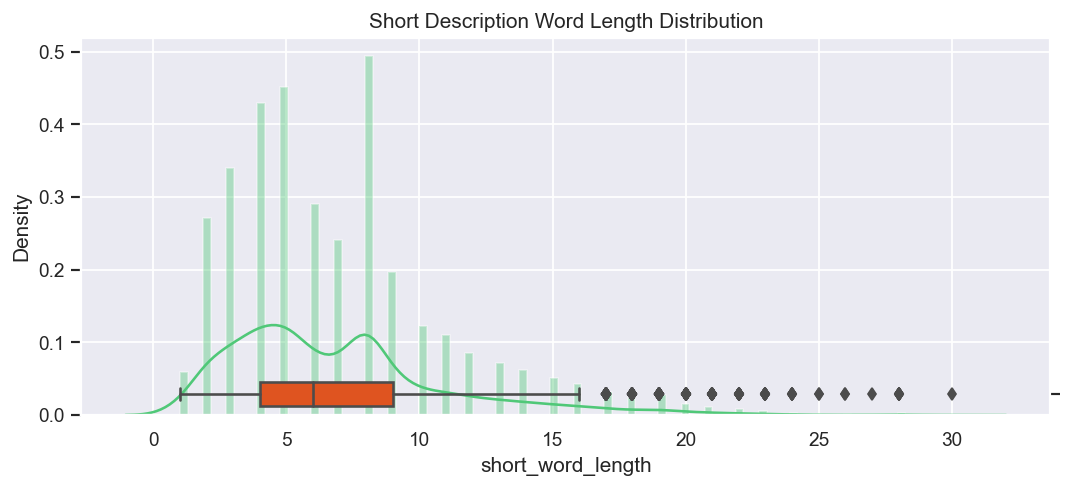

In [49]:
sns.set()
plt.figure(figsize=(10, 4), dpi=125)
ax = sns.distplot(dataset.short_word_length, bins=100, kde=True, color='#50C878')
ax_ = ax.twinx()
sns.boxplot(dataset.short_word_length, color='#FF4500')
ax_.set(ylim=(-.7, 12))
plt.title('Short Description Word Length Distribution')
plt.show()

In [50]:
sns.set()
plt.figure(figsize=(10, 4), dpi=125)
ax = sns.distplot(dataset.short_char_length, bins=100, kde=True, color='#50C878')
ax_ = ax.twinx()
sns.boxplot(dataset.short_char_length, color='#FF4500')
ax_.set(ylim=(-.7, 12))
plt.title('Short Description Char Length Distribution')
plt.show()

In [51]:
dataset.describe()

char_length  word_length  short_char_length  short_word_length
count   8499.000000  8499.000000        8499.000000        8499.000000
mean     204.595246    27.331804          47.386751           6.951759
std      519.530803    65.026307          27.323700           4.158631
min        3.000000     1.000000           2.000000           1.000000
25%       42.000000     6.000000          26.000000           4.000000
50%      106.000000    11.000000          41.000000           6.000000
75%      201.000000    28.000000          62.000000           9.000000
max    13001.000000  1625.000000         237.000000          30.000000

<h5><ul>
<span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">
    <li>Most descriptions have between 6 and 28 words long with median at 41 (106 characters) and mean at 27.2 with relatively few outliers ranging till 1625 words!<br>
    <li>Most Short descriptions have between 4 and 9 words long with median at 6 (41 characters) and mean at 6.92 with relatively few outliers ranging till 28 words.<br>
 </span></ul></h5>

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Word Frequency Distributions & WordClouds</span></strong></li>
</ul></h3>

In [56]:
# top 50 most frequent words in text
top_N = 50

words = (dataset.description.str.cat(sep=' ').split())
rslt = pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

In [57]:
rslt[:50].transpose()

Word         to   the    in    is  from:   and  received     i    on   for  \
Frequency  6296  6254  3172  2670   2499  2384      2354  2244  1977  1946   

Word       ...  can   we   as  access  when  site   am  account  ticket  error  
Frequency  ...  684  669  665     664   656   654  645      627     605    577  

[1 rows x 50 columns]

In [58]:
sns.set(font_scale=1.5)  # scale up font size
rslt.sort_values(by='Frequency', ascending=True).plot(kind='barh', width=1, figsize=(15, 15), color='#50C878')
plt.xticks(rotation=45)
plt.show()

In [59]:
pprint(rslt.index.tolist(), compact=True)

['to', 'the', 'in', 'is', 'from:', 'and', 'received', 'i', 'on', 'for', 'not',
 'a', 'please', 'of', '(yes/no/na)', '?', 'this', 'it', 'password', 'erp',
 'you', 'job', 'user', 'have', 'my', 'monitoring_tool@company.com', 'with',
 'failed', 'reset', 'job_scheduler', 'at:', 'from', 'unable', 'are', '-',
 'that', 'company', 'be', ':', 'at', 'can', 'we', 'as', 'access', 'when',
 'site', 'am', 'account', 'ticket', 'error']


<h5><ul>
<span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">
    <li>Stopwords and Anchor words like 'From:', 'Recieved' have to be stripped out
 </span></ul></h5>

In [60]:
# top 50 most frequent words in text
top_N = 50

words = (dataset.short_description.str.cat(sep=' ').split())
rslt = pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

In [61]:
rslt[:50].transpose()

Word         to    in  not  job   on   is  password  erp  failed  \
Frequency  2167  1737  981  976  917  856       847  822     822   

Word       job_scheduler  ...  with    i   my  crm  ticket  windows    /   am  \
Frequency            811  ...   193  191  187  185     182      177  177  168   

Word       password_management_tool  network  
Frequency                       161      155  

[1 rows x 50 columns]

In [62]:
sns.set(font_scale=1.5)  # scale up font size
rslt.sort_values(by='Frequency', ascending=True).plot(kind='barh', width=1, figsize=(15, 15), color='#50C878')
plt.xticks(rotation=45)
plt.show()

In [63]:
pprint(rslt.index.tolist(), compact=True)

['to', 'in', 'not', 'job', 'on', 'is', 'password', 'erp', 'failed',
 'job_scheduler', 'at:', 'for', 'the', 'unable', '-', 'reset', 'account',
 'issue', 'access', 'and', 'outlook', ':', 'login', 'down', 'SID_34', 'from',
 'locked', 'error', 'update', 'of', 'user', 'working', 'please', 'vpn', 'skype',
 'a', 'since', 'need', 'et', 'at', 'with', 'i', 'my', 'crm', 'ticket',
 'windows', '/', 'am', 'password_management_tool', 'network']


<h5><ul>
<span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">
    <li>Many stopwords are occuring most frequently in the dataset. We might need to use stopword removal in our pre-processing if it improves the model performance.
 </span></ul></h5>

In [64]:
descr_string = ""
for description in dataset['description']:
    descr_string += description
    descr_string += " "

short_descr_string = ""
for description in dataset['short_description']:
    short_descr_string += description
    short_descr_string += " "

grp0_string = ""
for description in temp.loc[temp.group == 'Group 0', 'description']:
    grp0_string += description
    grp0_string += " "

other_string = ""
for description in temp.loc[temp.group == 'Other', 'description']:
    other_string += description
    other_string += " "

<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Descriptions WordCloud</span></strong></li>
</ul></h4>

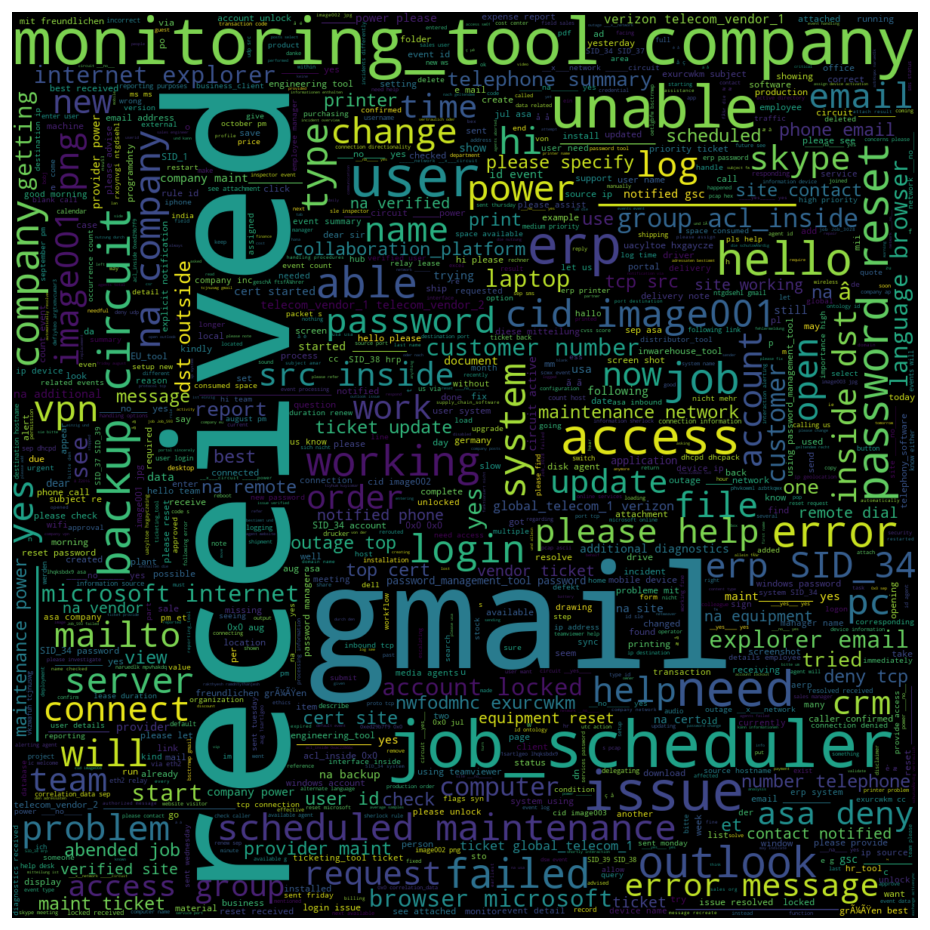

In [65]:
plt.figure(figsize=(10,10), dpi=120)
WC = WordCloud(width=1200, height=1200, max_words=1000, min_font_size=5)
plt.imshow(WC.generate(descr_string), interpolation='bilinear')
plt.axis("off")
plt.show()

<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Short Descriptions WordCloud</span></strong></li>
</ul></h4>

In [66]:
# Non-Sarcastic descriptions wordcloud
plt.figure(figsize=(10,10), dpi=120)
WC = WordCloud(width=1200, height=1200, max_words=1000, min_font_size=5)
plt.imshow(WC.generate(short_descr_string), interpolation='bilinear')
plt.axis("off")
plt.show()

<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Group 0 Descriptions WordCloud</span></strong></li>
</ul></h4>

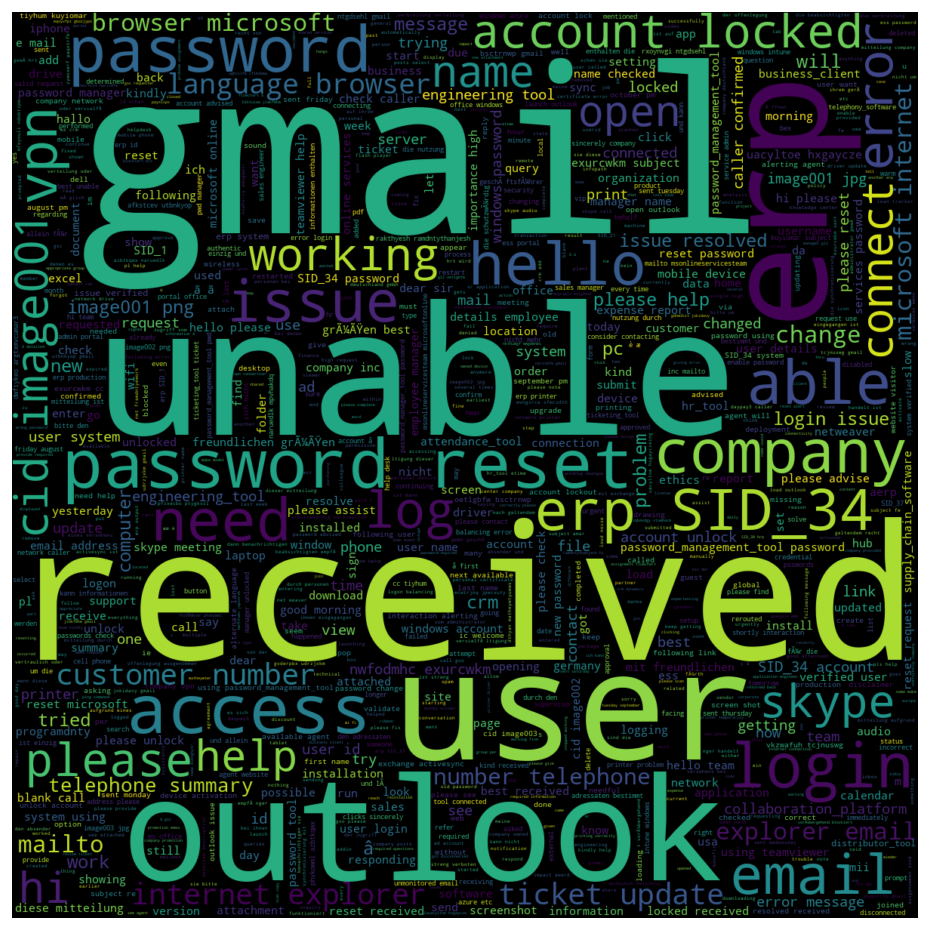

In [67]:
# Non-Sarcastic descriptions wordcloud
plt.figure(figsize=(10,10), dpi=120)
WC = WordCloud(width=1200, height=1200, max_words=1000, min_font_size=5)
plt.imshow(WC.generate(grp0_string), interpolation='bilinear')
plt.axis("off")
plt.show()

<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Other Groups Descriptions WordCloud</span></strong></li>
</ul></h4>

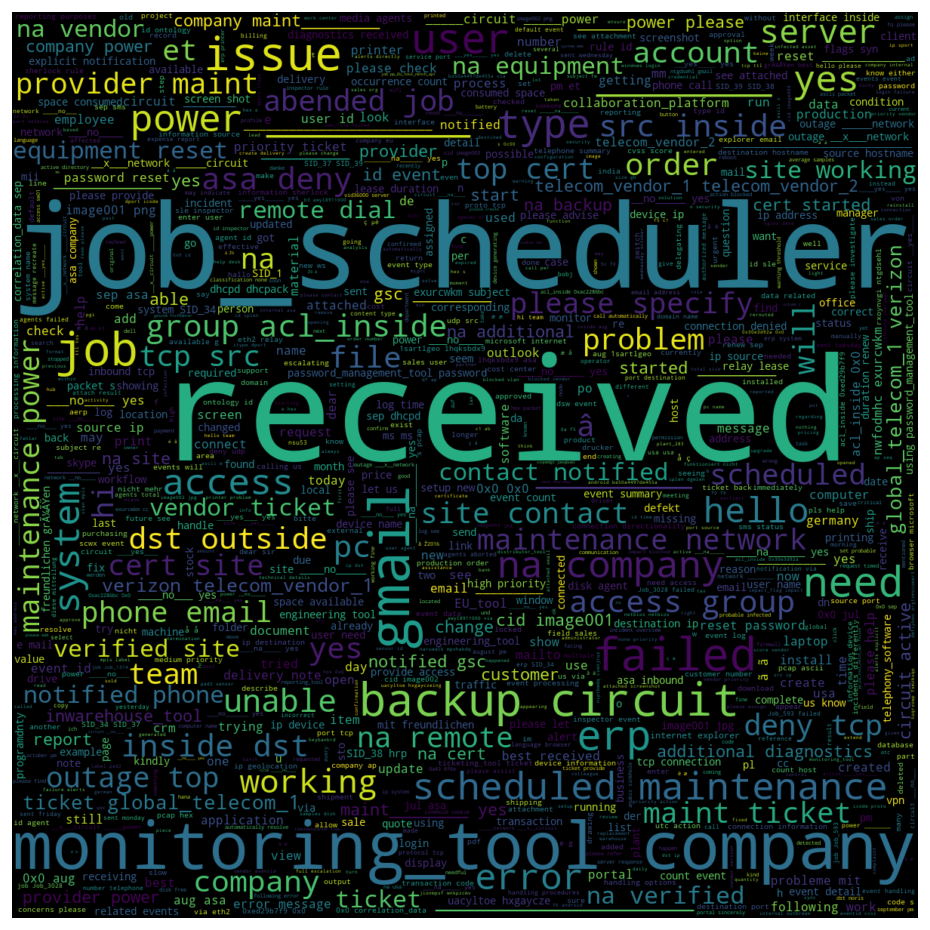

In [68]:
# Non-Sarcastic descriptions wordcloud
plt.figure(figsize=(10,10), dpi=120)
WC = WordCloud(width=1200, height=1200, max_words=1000, min_font_size=5)
plt.imshow(WC.generate(other_string), interpolation='bilinear')
plt.axis("off")
plt.show()

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Language Detection</span></strong></li>
</ul></h3>

In [69]:
# detect the languages in the dataset
languages = []
errs = []
lang_samples = defaultdict(list)
for text in tqdm(dataset.description):
    try:
        lang = detect_langs(text)
        clean_lang = str(lang).split(':')[0][1:]
        lang_samples[clean_lang].append(text)
        languages.append(clean_lang)
    except LangDetectException as e:
        errs.append(text)
        print('text: ', text)
        print(e)

 74%|████████████████████████████████████████████████████████▉                    | 6279/8499 [00:41<00:15, 145.38it/s]

text:  +86  
No features in text.


100%|█████████████████████████████████████████████████████████████████████████████| 8499/8499 [00:55<00:00, 153.99it/s]


In [70]:
print("Unique languages in the descriptions: "
      f"{np.unique(languages)}")

Unique languages in the descriptions: ['af' 'ca' 'cs' 'cy' 'da' 'de' 'en' 'es' 'et' 'fi' 'fr' 'hr' 'hu' 'id'
 'it' 'lt' 'lv' 'nl' 'no' 'pl' 'pt' 'ro' 'sk' 'sl' 'so' 'sq' 'sv' 'sw'
 'tl' 'tr']


In [71]:
lang_freqs = {i: len(lang_samples[i]) for i in lang_samples}
freq_df = pd.DataFrame({'Language': lang_freqs.keys(), 'Frequency': lang_freqs.values()},
                      columns=['Language', 'Frequency']).set_index('Language')
freq_df.T

Language     en  no   it   fr  es   af  ca  sv  nl   de  ...  hr  tr  fi  hu  \
Frequency  6997  80  150  118  58  271  62  80  62  393  ...   7   4   7   1   

Language   so  cs  sw  lt  lv  sk  
Frequency   4   2   1   2   1   1  

[1 rows x 30 columns]

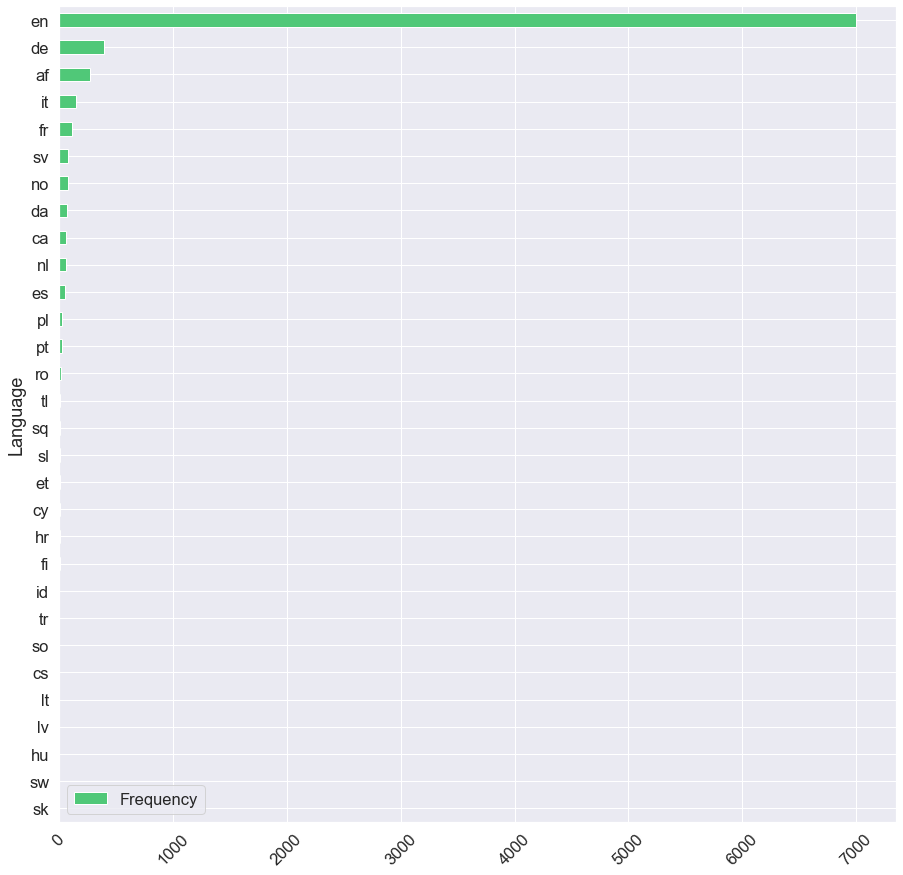

In [72]:
sns.set(font_scale=1.5)  # scale up font size
freq_df.sort_values(by='Frequency', ascending=True).plot(kind='barh', width=0.5, figsize=(15, 15), color='#50C878')
plt.xticks(rotation=45)
plt.show()

In [73]:
for i in lang_samples:
    print(i)
    try:
        print(random.sample(lang_samples[i], 3))
    except Exception:
        print(random.sample(lang_samples[i], 1))
    print('')

en
['expense report is blocked', 'blank call //gso // loud noise', 'vpn not working- vpn.company.com  link is giving error']

no
['skype meeting add-in getting disabled from outlook', '\n\nreceived from: ktghvuwr.uwtakcmj@gmail.com\n\nhello\n\nå…³äºŽbusiness_clientæ—\xa0æ³•ç™»å…¥çš„é—®é¢˜è¯·å¸®å¿™è§£å†³ï¼Œå\x8d³æ‰“å¼€business_clientè½¯ä»¶ï¼ŒçŽ°åœ¨æ—\xa0æ³•ç™»å…¥:\n\n1ï¼Žè¿žæŽ¥vpnå\x90Žï¼Œä»Žè½¯ä»¶ç«¯ç™»å…¥ä¸\x8dè¡Œï¼Œæ˜¾ç¤ºå¦‚ä¸‹ï¼š\n\n[cid:image001.jpg@01d22a56.4f7ef4c0]\n2ï¼Žä»Žç½‘é¡µç‰ˆç™»å…¥ï¼Œæ˜¾ç¤ºå¦‚ä¸‹ï¼Œå‡ºæ—\xa0æ³•ç™»å…¥ï¼š\n\n[cid:image002.jpg@01d22a56.4f7ef4c0]\n\n\n\nktghvuwr uwtakcmj\nsr. application engineer\noptimization team\nktghvuwr.uwtakcmj@gmail.com<mailto:ktghvuwr.uwtakcmj@gmail.com>', 'ç³»ç»Ÿä¸\xadçª\x81ç„¶æ‰¾ä¸\x8dåˆ°skype for businessäº†']

it
['skype issue ; personal certificate error ', 'unable to login to erp', 'etime- time card update information.']

fr
['email address confirmation', 'blank call // loud noise ', 'collaboration_platform é‡Œé\x9d¢æ‰“å¼€"æŸ¥çœ

In [74]:
# detect the languages in the dataset
languages = []
lang_samples = defaultdict(list)
for text in tqdm(dataset.short_description):
    try:
        lang = detect_langs(text)
        clean_lang = str(lang).split(':')[0][1:]
        lang_samples[clean_lang].append(text)
        languages.append(clean_lang)
    except LangDetectException as e:
        errs.append(text)
        print('text: ', text)
        print(e)

 22%|████████████████▊                                                            | 1855/8499 [00:15<00:58, 114.19it/s]

text:  bgflmyar.xgufkidq@gmail.com
No features in text.


 35%|███████████████████████████                                                  | 2986/8499 [00:24<00:43, 127.92it/s]

text:  ???????????????????
No features in text.


100%|█████████████████████████████████████████████████████████████████████████████| 8499/8499 [01:09<00:00, 122.34it/s]


In [75]:
print("Unique languages in the short descriptions: "
      f"{np.unique(languages)}")

Unique languages in the short descriptions: ['af' 'ca' 'cs' 'cy' 'da' 'de' 'en' 'es' 'et' 'fi' 'fr' 'hr' 'id' 'it'
 'lt' 'lv' 'nl' 'no' 'pl' 'pt' 'ro' 'sk' 'sl' 'so' 'sq' 'sv' 'sw' 'tl'
 'tr' 'vi']


In [76]:
lang_freqs = {i: len(lang_samples[i]) for i in lang_samples}
freq_df = pd.DataFrame({'Language': lang_freqs.keys(), 'Frequency': lang_freqs.values()},
                       columns=['Language', 'Frequency']).set_index('Language')
freq_df.T

Language    it  et    en   no  es   nl   af   ca   sv  ro  ...  sk  sq  vi  \
Frequency  276  15  6015  169  86  156  497  107  100  53  ...  13  17   3   

Language   hr  pt  tr  so  sw  lv  lt  
Frequency   6  33   8   5   1   4   6  

[1 rows x 30 columns]

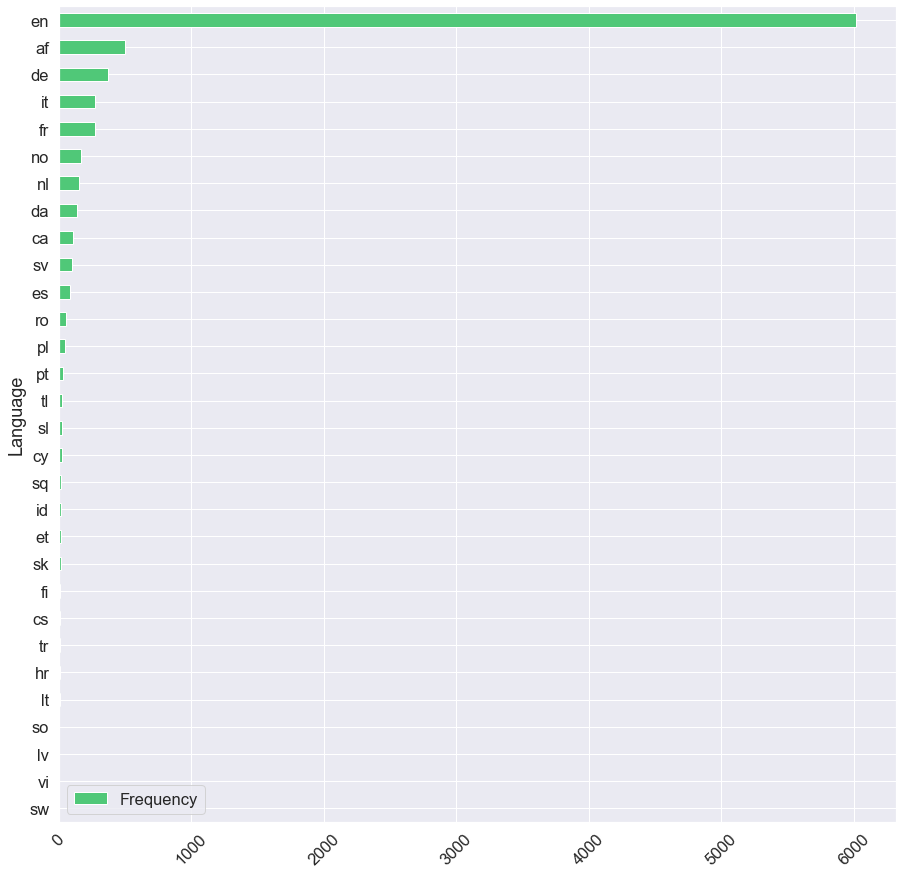

In [77]:
sns.set(font_scale=1.5)  # scale up font size
freq_df.sort_values(by='Frequency', ascending=True).plot(kind='barh', width=0.5, figsize=(15, 15), color='#50C878')
plt.xticks(rotation=45)
plt.show()

In [78]:
for i in lang_samples:
    print(i)
    try:
        print(random.sample(lang_samples[i], 3))
    except Exception:
        print(random.sample(lang_samples[i], 1))
    print('')

it
['data card', 'vpnå®‰è£…-è½¬è´ºæ\xad£å¹³', 'german call']

et
['outlook', 'outlook', 'emailing: 16-177747.htm']

en
['user needs help to login to the mii.', 'job HostName_1019failagain_1 failed in job_scheduler at: 08/24/2016 12:56:00  ', 'job SID_41hotf failed in job_scheduler at: 08/23/2016 12:45:00  ']

no
['telefon defekt ', 'password reset alert from o365', 'skype issues']

es
['erp logon SID_34 & SID_37', 'unable to connect to vpn', 'unable to create dn']

nl
['create delivery note  2053495 / plant plant_120 / slc 0088 / apo error / urgent  eilt', 'probleme mit barcode etiketten \\volume format zu groÃŸ \\vzqomdgt jwoqbuml', 'rechner optiplex790 defekt \\ ewew8323670 \\xpugntjv zcaermdt']

af
['reset my password', 'skype audio not working', 'outlook does not start.']

ca
['crm problems', 'e&o access request for partner team', 'probleme mit erpgui \\tmqfjard qzhgdoua']

sv
['ticket update for-ticket_no0447000', 'vvdortddp', 'æ˜¾ç¤ºå™¨ä¸\x8däº®']

ro
['ie cleanup', 'customer mas

In [79]:
errs  # few errors where lang_detect failed, need to impute these irrelevant values

['+86  ', 'bgflmyar.xgufkidq@gmail.com', '???????????????????']

In [80]:
dataset[dataset.description == errs[0]]

short_description description  \
6253  in the inbox always show there are several ema...       +86     

                 caller  group  char_length  word_length  short_char_length  \
6253  mqbxwpfn uclrqfxa  GRP_0            5            1                 94   

      short_word_length  
6253                 19

In [81]:
dataset.loc[dataset.description == errs[0], 'description'] = dataset[dataset.description == errs[0]].short_description

In [82]:
dataset[dataset.short_description == errs[1]]

short_description  \
1836  bgflmyar.xgufkidq@gmail.com   

                                            description             caller  \
1836  bgflmyar.xgufkidq@gmail.com wanted to check if...  olckhmvx pcqobjnd   

      group  char_length  word_length  short_char_length  short_word_length  
1836  GRP_0           83           13                 27                  1

In [83]:
dataset.loc[dataset.short_description == errs[1], 'short_description'] = dataset[dataset.short_description == errs[1]].description

In [84]:
dataset[dataset.short_description == errs[2]]

short_description                                        description  \
2975  ???????????????????  \r\n\r\nreceived from: yzbjhmpw.vzrulkog@gmail...   

                 caller  group  char_length  word_length  short_char_length  \
2975  yzbjhmpw vzrulkog  GRP_0         1207          131                 19   

      short_word_length  
2975                  1

In [85]:
dataset.loc[dataset.short_description == errs[2], 'short_description'] = dataset[dataset.short_description == errs[2]].description

<h4><ul>
<span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">
    <li>Retain only relevant columns. Caller seems to be information about callers that was obfuscated and anonymized for privacy reasons
 </span></ul></h4>

In [86]:
dataset.drop('caller', axis=1, inplace=True)

In [87]:
dataset.sample(50)

short_description  \
3746     tax not printing on customer inwarehouse_tools   
470                                  access to s drive.   
5735                            unable to login to erp    
3041  client 0819 company, inc / rejected edi inware...   
6593  german call // caller disconnected after heari...   
2026              business_client : .net error message    
6671  advanced search does not use the material fiel...   
2041    need converion tool : export a pdf into excel.    
8427  new employee not able to login to system vvrtg...   
3212                              skype is not opening.   
7954  mobile device is temporarily blocked from sync...   
2640           audio issue : windows audio issue ; 7350   
280                          erp SID_34 account locked    
6815                                    kpm not working   
4258  user wanted to speak to some one in usa and as...   
2992  reactivate ruenzm - it is our ceo (usa - delor...   
2650                    ticket update on inplant_865534   
2684            extend the account - vvnewthey - urgent   
730   reset passwords for qkgnwxto dwtivjrp using pa...   
4841         windows password reset for tinmuym alrthyu   
4678                           mobile device activated.   
4761  job SID_37hoti failed in job_scheduler at: 09/...   
6457  background jobs in erp inbox will not export i...   
906   der monitor an unser lÃ¤ngenmessmaschine ist d...   
6340             probleme mit erpgui \vsdtxwry ngkcdjye   
8471                           ç”µè„‘å¼€æœºå¼€ä¸å‡ºæ¥   
5066                        outlook not updating emails   
2481                             windows account unlock   
3873                                            request   
4165  job Job_1967b failed in job_scheduler at: 09/1...   
2103                         erp SID_34 account locked    
6967                    ticket update on inplant_852167   
1284              EU_tool performance is very low again   
1223                         erp SID_34 password change   
1810                     carrier orders not processing.   
4480  monthly quality working group (qwg) - global r...   
1020                   not able to access walkme plugin   
474   HostName_1030 is currently experiencing high c...   
3019                              business_client issue   
4824  unable to add contacts to markhtyeting list to...   
5509              password chaning for window (company)   
5813                                     outlook issue    
3447  reset passwords for qoybxkfh dwcmxuea using pa...   
2534                              business_client issue   
1981  telephone repair  pu-4 (shop floor 173 connect...   
2747                                     outlook issues   
3664                    password reset as it is expired   
4833                                  erp will not open   
4895  unlock exchange active sync for ios for vmthcr...   
6571            login + password very urgent for esprit   

                                            description   group  char_length  \
3746  please review the attached inwarehouse_tools, ...  GRP_13          517   
470   \r\n\r\nreceived from: wnvlmsjr.znbvlygd@gmail...  GRP_12          133   
5735                             unable to login to erp   GRP_0           22   
3041  from: nihtykki mcgyuouald  \nsent: tuesday, se...  GRP_32          320   
6593  german call // caller disconnected after heari...   GRP_0           56   
2026              business_client : .net error message    GRP_0           37   
6671  the same set of results is returned regardless...  GRP_25          100   
2041  \nsummary:hello,\ni saw on pdf options that it...  GRP_33          154   
8427   user id : vvrtgwildj\nname : johghajknnes wil...   GRP_0          386   
3212                              skype is not opening.   GRP_0           21   
7954  from: grhryueg dewicrth \r\nsent: wednesday, a...   GRP_0          316   
2640           audio issue : windows audio issue ; 7350   GRP_0     

<h2><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Pre-Processing</span></strong></li>
</ul></h2>

### Pipeline
* clean up security logs
* clean up emails, links ...
* clean html tags if they exist
* clean /r /n characters
* translate accented characters (á -> a)
* convert unicode characters to ascii
* expand contractions (they're -> they are)
* clean up anchor words like: 'Received from:', 'name:', 'hello', 'hello team' , 'cid' ...
* handle other languages (drop or translate)
* clean stopwords & add any custom stopwords if req.
* tokenize
* clean up extra whitespaces, strip extra punctuation
* lemmatization/stemming (if needed for a model)

### TODO: Handle security incidents and event logs

### TODO: Handle cleaning of email headers and footers

### TODO: Handle language translation

### TODO: Handle Gibberish Removal

* Clean up Emails, Links, Dates, Telephone Numbers

In [88]:
# !pip install spacy
# !python -m spacy downlaod en_core_web_sm
# !pip install contractions
import nltk
import spacy

nltk.download('punkt')
nltk.download('stopwords')
# Initialize spacy 'en_core_web_sm' model
nlp = spacy.load('en_core_web_sm', disable=['parser'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\surya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\surya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [89]:
from utils.link_handler import LinkHandler
from utils.email_handler import EmailHandler
from utils.date_handler import DateHandler
from utils.tel_handler import TelHandler

In [90]:
test = "Date: 12/2/2024" 
doc = nlp(test)
toks = [t.text for t in doc]
toks = [t.strip() for t in toks]
text = " ".join(toks)
tags = ['O']*len(doc)
tag = "DATE"
date_hdlr = DateHandler()
date_indices = date_hdlr.match_ref(text, toks, tags,
                                   entity=tag,
                                   verbose=True)
tags = ['DATE' if idx in date_indices else 'O'
        for idx in range(len(toks))]
print(text)
print(toks)
print(tags)
pprint(list(zip(toks, tags)), compact=True)


Final Matches DATE: ['12/2/2024']

Date : 12/2/2024
['Date', ':', '12/2/2024']
['O', 'O', 'DATE']
[('Date', 'O'), (':', 'O'), ('12/2/2024', 'DATE')]


In [91]:
test = "mailto: john.doe@gmail.com from: jane.doe@outlook.com"
doc = nlp(test)
toks = [t.text for t in doc]
toks = [t.strip() for t in toks]
text = " ".join(toks)
tags = ['O']*len(doc)
tag = "MAIL"
email_hdlr = EmailHandler()
email_indices = email_hdlr.match_ref(text, toks, tags,
                                     entity=tag,
                                     verbose=True)
tags = [tag if idx in email_indices else 'O'
        for idx in range(len(toks))]
print(text)
print(toks)
print(tags)
pprint(list(zip(toks, tags)), compact=True)


Final Matches MAIL: ['john.doe@gmail.com', 'jane.doe@outlook.com']

mailto : john.doe@gmail.com from : jane.doe@outlook.com
['mailto', ':', 'john.doe@gmail.com', 'from', ':', 'jane.doe@outlook.com']
['O', 'O', 'MAIL', 'O', 'O', 'MAIL']
[('mailto', 'O'), (':', 'O'), ('john.doe@gmail.com', 'MAIL'), ('from', 'O'),
 (':', 'O'), ('jane.doe@outlook.com', 'MAIL')]


In [92]:
test = "www.google.com/?search Search Results: ..." 
doc = nlp(test)
toks = [t.text for t in doc]
toks = [t.strip() for t in toks]
text = " ".join(toks)
tags = ['O']*len(doc)
tag = "LINK"
link_hdlr = LinkHandler()
link_indices = link_hdlr.match_ref(text, toks, tags,
                                   entity=tag,
                                   verbose=True)
tags = [tag if idx in link_indices else 'O'
        for idx in range(len(toks))]
print(text)
print(toks)
print(tags)
pprint(list(zip(toks, tags)), compact=True)


Final Matches LINK: ['www.google.com/?search']

www.google.com/?search Search Results : ...
['www.google.com/?search', 'Search', 'Results', ':', '...']
['LINK', 'O', 'O', 'O', 'O']
[('www.google.com/?search', 'LINK'), ('Search', 'O'), ('Results', 'O'),
 (':', 'O'), ('...', 'O')]


In [93]:
test = "Tel +1 724 539 5257" 
doc = nlp(test)
toks = [t.text for t in doc]
toks = [t.strip() for t in toks]
text = " ".join(toks)
tags = ['O']*len(doc)
tag = "TEL"
tel_hdlr = TelHandler()
tel_indices = tel_hdlr.match_ref(text, toks, tags,
                                 entity=tag,
                                 verbose=True)
tags = [tag if idx in tel_indices else 'O'
        for idx in range(len(toks))]
print(text)
print(toks)
print(tags)
pprint(list(zip(toks, tags)), compact=True)


Final Matches TEL: ['Tel', '+1', '724', '539', '5257']

Tel +1 724 539 5257
['Tel', '+1', '724', '539', '5257']
['TEL', 'TEL', 'TEL', 'TEL', 'TEL']
[('Tel', 'TEL'), ('+1', 'TEL'), ('724', 'TEL'), ('539', 'TEL'), ('5257', 'TEL')]


In [94]:
# find all rows with email addresses in them
email_messages = list()

for text in tqdm(dataset.description):
    doc = nlp(text)
    toks = [t.text for t in doc]
    toks = [t.strip() for t in toks]
    text = " ".join(toks)
    tags = ['O']*len(doc)
    tag = "MAIL"
    email_indices = email_hdlr.match_ref(text, toks, tags,
                                         entity=tag,
                                         verbose=False)
    tags = [tag if idx in email_indices else 'O'
            for idx in range(len(toks))]
    if 'MAIL' in tags:
        email_messages.append(text)

100%|█████████████████████████████████████████████████████████████████████████████| 8499/8499 [00:48<00:00, 174.46it/s]


In [95]:
# find all rows with email addresses in them
email_shorts = list()

for text in tqdm(dataset.short_description):
    doc = nlp(text)
    toks = [t.text for t in doc]
    toks = [t.strip() for t in toks]
    text = " ".join(toks)
    tags = ['O']*len(doc)
    tag = "MAIL"
    email_indices = email_hdlr.match_ref(text, toks, tags,
                                         entity=tag,
                                         verbose=False)
    tags = [tag if idx in email_indices else 'O'
            for idx in range(len(toks))]
    if tag in tags:
        email_shorts.append(text)

100%|█████████████████████████████████████████████████████████████████████████████| 8499/8499 [00:26<00:00, 325.25it/s]


In [96]:
len(email_messages), len(email_shorts)

(2616, 60)

In [133]:
# for i in random.sample(email_messages, 10):
#     print(i); print()

In [134]:
# for i in random.sample(email_shorts, 10):
#     print(i); print()

In [99]:
# find dates
dates = list()

for text in tqdm(dataset.description):
    doc = nlp(text)
    toks = [t.text for t in doc]
    toks = [t.strip() for t in toks]
    text = " ".join(toks)
    tags = ['O']*len(doc)
    tag = "DATE"
    date_indices = date_hdlr.match_ref(text, toks, tags,
                                       entity=tag,
                                       verbose=False)
    tags = [tag if idx in date_indices else 'O'
            for idx in range(len(toks))]
    if tag in tags:
        dates.append(text)

100%|█████████████████████████████████████████████████████████████████████████████| 8499/8499 [00:48<00:00, 176.69it/s]


In [100]:
# find dates
dates_short = list()

for text in tqdm(dataset.short_description):
    doc = nlp(text)
    toks = [t.text for t in doc]
    toks = [t.strip() for t in toks]
    text = " ".join(toks)
    tags = ['O']*len(doc)
    tag = "DATE"
    date_indices = date_hdlr.match_ref(text, toks, tags,
                                       entity=tag,
                                       verbose=False)
    tags = [tag if idx in date_indices else 'O'
            for idx in range(len(toks))]
    if tag in tags:
        dates_short.append(text)

100%|█████████████████████████████████████████████████████████████████████████████| 8499/8499 [00:27<00:00, 311.43it/s]


In [101]:
len(dates), len(dates_short)

(1566, 1035)

In [131]:
# for i in random.sample(dates, 10):
#     print(i); print()

In [132]:
# for i in random.sample(dates_short, 10):
#     print(i); print()

In [104]:
# find web links
links = list()

for text in tqdm(dataset.description):
    doc = nlp(text)
    toks = [t.text for t in doc]
    toks = [t.strip() for t in toks]
    text = " ".join(toks)
    tags = ['O']*len(doc)
    tag = "LINK"
    link_indices = link_hdlr.match_ref(text, toks, tags,
                                       entity=tag,
                                       verbose=False)
    tags = [tag if idx in link_indices else 'O'
            for idx in range(len(toks))]
    if tag in tags:
        links.append(text)

100%|█████████████████████████████████████████████████████████████████████████████| 8499/8499 [00:47<00:00, 180.61it/s]


In [105]:
# find web links
links_short = list()

for text in tqdm(dataset.short_description):
    doc = nlp(text)
    toks = [t.text for t in doc]
    toks = [t.strip() for t in toks]
    text = " ".join(toks)
    tags = ['O']*len(doc)
    tag = "LINK"
    link_indices = link_hdlr.match_ref(text, toks, tags,
                                       entity=tag,
                                       verbose=False)
    tags = [tag if idx in link_indices else 'O'
            for idx in range(len(toks))]
    if tag in tags:
        links_short.append(text)

100%|█████████████████████████████████████████████████████████████████████████████| 8499/8499 [00:26<00:00, 320.09it/s]


In [106]:
len(links), len(links_short)

(163, 58)

In [130]:
# for i in random.sample(links, 10):
#     print(i); print()

In [129]:
# for i in random.sample(links_short, 10):
#     print(i); print()

In [109]:
# find web links
tels = list()

for text in tqdm(dataset.description):
    doc = nlp(text)
    toks = [t.text for t in doc]
    toks = [t.strip() for t in toks]
    text = " ".join(toks)
    tags = ['O']*len(doc)
    tag = "TEL"
    tel_indices = tel_hdlr.match_ref(text, toks, tags,
                                     entity=tag,
                                     verbose=False)
    tags = [tag if idx in tel_indices else 'O'
            for idx in range(len(toks))]
    if tag in tags:
        tels.append(text)

100%|█████████████████████████████████████████████████████████████████████████████| 8499/8499 [00:50<00:00, 169.45it/s]


In [110]:
# find web links
tels_short = list()

for text in tqdm(dataset.short_description):
    doc = nlp(text)
    toks = [t.text for t in doc]
    toks = [t.strip() for t in toks]
    text = " ".join(toks)
    tags = ['O']*len(doc)
    tag = "TEL"
    tel_hdlr = TelHandler()
    tel_indices = tel_hdlr.match_ref(text, toks, tags,
                                     entity=tag,
                                     verbose=False)
    tags = [tag if idx in tel_indices else 'O'
            for idx in range(len(toks))]
    if tag in tags:
        tels_short.append(text)

100%|█████████████████████████████████████████████████████████████████████████████| 8499/8499 [00:29<00:00, 288.02it/s]


In [111]:
len(tels), len(tels_short)

(23, 2)

In [127]:
# for i in random.sample(tels, 10):
#     print(i); print()

In [128]:
# for i in tels_short:
#     print(i); print()

In [114]:
def clean_irrelevant_info(text: str) -> str:
    '''strips out emails, dates, website links and telephone numbers in the text'''
    doc = nlp(text)
    toks = [t.text for t in doc]
    toks = [t.strip() for t in toks]
    text = " ".join(toks)
    tags = ['O']*len(doc)
    tel_indices = tel_hdlr.match_ref(text, toks, tags,
                                     entity='TEL',
                                     verbose=False)
    tags = ['TEL' if idx in tel_indices else 'O'
            for idx in range(len(toks))]
    link_indices = link_hdlr.match_ref(text, toks, tags,
                                       entity='LINK',
                                       verbose=False)
    tags = ['LINK' if idx in link_indices else tag
            for idx, tag in enumerate(tags)]
    date_indices = date_hdlr.match_ref(text, toks, tags,
                                       entity='DATE',
                                       verbose=False)
    tags = ['DATE' if idx in date_indices else tag
            for idx, tag in enumerate(tags)]
    email_indices = email_hdlr.match_ref(text, toks, tags,
                                         entity='MAIL',
                                         verbose=False)
    tags = ['MAIL' if idx in email_indices else tag
            for idx, tag in enumerate(tags)]
    # print(toks)
    # print(tags)
    # print([tok for tok, tag in zip(toks, tags) if tag == "O"])
    return str(" ".join([tok for tok, tag in zip(toks, tags) if tag == "O"]))

In [115]:
%%time

test = "Tel +1 724 539 5257 www.google.com/?search Search Results: ... Date: 12/2/2024 mailto: john.doe@gmail.com from: jane.doe@outlook.com"
clean_irrelevant_info(test)

Wall time: 8.99 ms


'Search Results : ... Date : mailto : from :'

* Clean Anchors

In [116]:
import re

anchors = {'received from:', 'received from :', 'received from:',
           'from:', 'to:', 'from :', 'to :', 'hi', 'hello', 'dear team',
           'date:', 'date :', 'cid', 'good morning', 'good morning,'
          }

def clean_anchors(text: str, anchors=anchors) -> str:
    '''strips out anchor words'''
    for anchor in anchors:
        text = re.sub(anchor, '', text.strip()).strip()
    return str(text.strip())

In [117]:
%%time

clean_anchors('received from: zfburidj.jmilguev@gmail.com')

Wall time: 0 ns


'received  zfburidj.jmilguev@gmail.com'

* Regular Preprocessing 

In [118]:
# utility functions for text preprocesing
import string
import unicodedata
import contractions
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer

CUSTOM = True

stemmer = SnowballStemmer('english')
if CUSTOM:
    stop_words = set(nltk.corpus.stopwords.words('english'))
    # custom stopwords added from the most frequent words which are generic 
    # and might not relate to the sentiment of the review
    stop_words.update(['urllink'])
else:
    stop_words = set(nltk.corpus.stopwords.words('english'))


def replace_accented_chars(text: str) -> str:
    '''normalizes and replaces accented characters'''
    unaccented_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return str(unaccented_text)



def strip_html_tags(text: str) -> str:
    '''strips html tags like <h4> ..etc'''
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return str(stripped_text)


def expand_contractions(text: str) -> str:
    text = contractions.fix(text)
    return str(text)


def remove_special_characters(text: str) -> str:
    '''
    Remove special characters but preserve digits and excalamation marks
    as they indicate emotionally charged review '''
    text = re.sub(r"[^A-Za-z0-9!?\'\`]", " ", text)
    return str(text)


def strip_stops(text: str, is_lower_case=False, stop_words=stop_words) -> str:
    '''strip stopwrds'''
    tokens = text.split()
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stop_words]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    filtered_text = ' '.join(filtered_tokens)    
    return str(filtered_text)


def snowball_stem(text: str, stemmer=stemmer) -> str:
    '''stemming using snowball stemmer'''
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    text = " ".join(stemmed_words)
    return str(text)


def tokenize(text: str) -> str:
    '''tokenize using spaCy'''
    doc = nlp(text)
    return str(" ".join([t.text for t in doc]))


def lemmatize(text: str) -> str:
    '''lemmatize using spaCy'''
    doc = nlp(text)
    return str(" ".join([t.lemma_ for t in doc]))

In [120]:
def preprocess_text(text: str,
                    lower=True,
                    strip_stopwords=False,
                    clean_anchor=True,
                    clean_irrelevant=True,
                    remove_special=True,
                    translate_to_english=True,
                    tokenize_text=True,
                    clean_whitespace=True) -> str:
    '''performs all preprocessing techniques on a string sto return a cleaned string'''
    if clean_irrelevant:
        text = clean_irrelevant_info(text)

    # TODO
    if translate_to_english:
        pass

    text = replace_accented_chars(text)
    text = strip_html_tags(text)    
    text = expand_contractions(text)

    if tokenize_text:
        text = tokenize(text)

    if lower:
        text = text.lower()

    if clean_anchor:
        text = clean_anchors(text)

    if remove_special:
        text = remove_special_characters(text)

    if strip_stopwords:
        text = strip_stops(text)
    
    if clean_whitespace:
        text = ' '.join(text.split())

    return str(text.strip())

In [135]:
test = """
received from: phfduvwl.yqnaucep@gmail.com

hello
i failed to login my hpqc account and got below message.
could you please reset password for my hpqc account, i need it to do uacyltoe hxgaycze next week
my user id is zhudrs

[cid:image001.png@01SID_358c2.0b26f430]
"""

In [136]:
%%time

cleaned = preprocess_text(test)
print(cleaned)

received from hello i failed to login my hpqc account and got below message could you please reset password for my hpqc account i need it to do uacyltoe hxgaycze next week my user i d is zhudrs image001 png 01sid 358c2 0b26f430
Wall time: 15 ms


In [122]:
def preprocess(row):
    descr = row.description
    short_descr = row.short_description

    if isinstance(descr, str):
        descr = preprocess_text(descr)
    else:
        descr = np.nan
    row['cleaned_description'] = descr
    
    if isinstance(short_descr, str):
        short_descr = preprocess_text(short_descr)
    else:
        short_descr = np.nan
    row['cleaned_short_description'] = short_descr

    return row

In [123]:
dataset = dataset.progress_apply(preprocess, axis=1)

100%|██████████████████████████████████████████████████████████████████████████████| 8499/8499 [03:02<00:00, 46.61it/s]


In [124]:
dataset.isna().sum()

short_description            0
description                  0
group                        0
char_length                  0
word_length                  0
short_char_length            0
short_word_length            0
cleaned_description          0
cleaned_short_description    0
dtype: int64

In [125]:
# claned dataset
dataset.sample(50)[['description', 'cleaned_description', 'short_description', 'cleaned_short_description']]

description  \
1978                          erp SID_34 password reset   
3269  \r\n\r\nreceived from: nxlzpgfr.rlqowmyt@gmail...   
6899  ebhsm004:   volume: e:\ label:dat1-ebhsm004 dc...   
6351                     password reset alert from o365   
1381  \r\n\r\nreceived from: rlphwiqn.zagvbkro@gmail...   
4807  \r\n\r\nreceived from: kehtxprg.uekapfzt@gmail...   
5032  reset the password for iwtvrhnz rxiumhfk on er...   
1900                      paper jam for insert printer    
2590  only erp running slow.\ninternet is working fi...   
6944            outlook not responding due to crm error   
2273  \nsummary:i hit the wrong button and messed up...   
626   \n\nreceived from: zuxcfonv.nyhpkrbe@gmail.com...   
5212                                         blank call   
8371  from: microsoft on behalf of company inc. [mai...   
1063  received from: monitoring_tool@company.com\r\n...   
7051  hello team,\n\ncould you please unlock account...   
5744  \r\n\r\nreceived from: ilbkhgxd.hirsqytd@gmail...   
3017  erp inbox for smitrtgcj1 is not working.  i ha...   
1375                            windows account lockout   
6512  messsgeraete alkoana pdf datein kann nicht ged...   
315                need to map mailboxes of colleagues.   
7271  windows disk space utilization alert for  :: H...   
827                     ticket update on inplant_871350   
7919  engineering tool is getting locked out frequen...   
7822   change erp logon language from german to english   
4858  \n\nreceived from: marhty.financial@company.co...   
2990  \r\n\r\nreceived from: bcxpeuko.utorqehx@gmail...   
3391                 ticket update for ticket_no0442691   
5184       terminated user called for access to the hub   
3539  \n\nreceived from: zwirhcol.narzlmfw@gmail.com...   
1750                ticket update on : ticket_no0447258   
5576  telefonanlage - nebenstelle 20 auf wild marfht...   
3578  hello,\r\n\r\ni'm unable to login on the bcd t...   
2934             probleme mit portal \acqpinyd ecygimqd   
6079  name:megfgthyhana\nlanguage:\nbrowser:microsof...   
6552  request to reset microsoft online services pas...   
593   german workflow objects from all folders are g...   
6169                                  connecting to vpn   
3599  \r\n\r\nreceived from: hctduems.znalhivf@gmail...   
6202  \r\n\r\nreceived from: ebqdmgpk.daoyrtmj@gmail...   
4672  reset passwords for robhyertyj f duca using pa...   
4897  \r\n\r\nreceived from: pnroqajb.psbyfhkg@gmail...   
7816  this was supposed to be removed immediately af...   
2009                    ticket update on inplant_867667   
1683                    account is getting locked daily   
3669                    connect 2 in 1 to companysecure   
1603                            ms office : word issue    
3704  gartryhuï¼š\r\nä½ å¥½ï¼Œä»Žæ˜¨å¤©æ™šä¸Šå¼€å§‹ï...   
1305  received from: monitoring_tool@company.com\r\n...   
3809                        erp SID_34 account locked.    

                                    cleaned_description  \
1978                          erp sid 34 password reset   
3269  received from i am unable to open the mails pl...   
6899  ebhsm004 volume e label dat1 ebhsm004 dc16126c...   
6351                     password reset alert from o365   
1381  received from hello i need help saving an exe ...   
4807  received from hello company it help for some r...   
5032  reset the password for iwtvrhnz rxiumhfk on er...   
1900                       paper jam for insert printer   
2590  only erp running slow internet is working fine...   
6944            outlook not responding due to crm error   
2273  summary i hit the wrong button and messed up m...   
626   received from gso currently erp system product...   
5212                                         blank call   
8371  microsoft on behalf of company inc sent friday...   
1063  received job job 1967d failed in job scheduler...   
7051  hello team could you please unlock account ema...   
5744  received from help desk f